# Infere with recommender system

In [1]:
# This ensures all modules are re-imported when import is called. This is useful for easier development and debugging.
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

## Load modules

In [2]:
# Import NumPy, pandas, matplotlib and PyTorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)



# Import sklearn modules
from sklearn.metrics.pairwise import cosine_similarity

# Import Utility Functions
import pickle
import json
import os
from tqdm import tqdm

# Import custom modules
from modelling.preprocessing import feature_engineering, get_bin_labels
from engine.utils import most_similar_index, calculateCriterion, calc_dh_tol
from crecsys import ZRMrecsys


In [5]:
df = pd.read_pickle("data/dataset.pkl")

## Calculate optimal dh_tol function


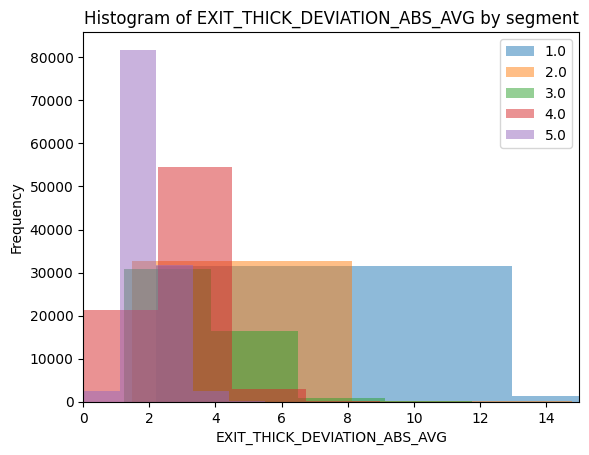

In [7]:
col = 'EXIT_THICK_DEVIATION_ABS_AVG'
grouped = df.groupby('pass_nr')

# plot histograms for each group on same plot
fig, ax = plt.subplots()
for name, group in grouped:
    ax.hist(group[col], bins=10, alpha=0.5, label=name)

# set plot properties
plt.legend()
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {} by segment'.format(col))
plt.xlim([0,15])

# show plot
plt.show()

y = -3.40462 * x + 0.34850 * x^2 + 10.50239


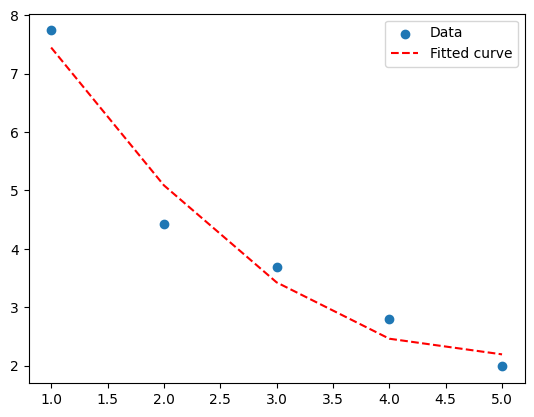

In [10]:
x = np.arange(1,6)
y = grouped[col].mean().values
from scipy.optimize import curve_fit

# define the true objective function
def objective(x, a, b, c):
 return a * x + b * x**2 + c

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
plt.scatter(x, y, label='Data')
x_line = np.arange(min(x), max(x+1), 1)
y_line = objective(x_line, a, b, c)
plt.plot(x_line, y_line, '--', color='red', label='Fitted curve')
plt.legend()
plt.show()

In [11]:
df_l = df.copy()
numeric_cols = df_l.select_dtypes(include='number').columns.values
df_l = df_l.groupby(['coil_id', 'pass_nr'])


# Define aggregation functions for different columns
agg_functions = {col: "median" for col in numeric_cols}
agg_functions['class'] = 'last'
agg_functions['coil_id'] = 'last'
# Apply aggregation functions to the grouped DataFrame
df_l = df_l.agg(agg_functions).reset_index(drop=True)

## Manual optimization

In [12]:
data = df_l.iloc[[2566]]

In [15]:
lambda1 = 0.6
pass_nr = int(data["pass_nr"].iloc[0])
dh_tol = calc_dh_tol(pass_nr, data['REF_INITIAL_THICKNESS'].iloc[0])
#print(pass_nr, dh_tol)
recsys_obj = ZRMrecsys()

coil_df = data.copy()

new_coil, new_coil_idx = recsys_obj.preprocess_coil_data(coil_df)
act_used = data.iloc[[0]][['tension_en', 'tension_ex', 'velocity_mdr']].copy()

act_used['pred'] = recsys_obj.predictQuality(act_used, new_coil, new_coil_idx)

res1 = recsys_obj.recommend(coil_df, pass_nr, dh_tol, lambda1)
#print(res1[0])
res2 = recsys_obj.optimize(coil_df, pass_nr, dh_tol, lambda1)
#print(res2)
res3 = recsys_obj.optimize_adv(coil_df, pass_nr, dh_tol, lambda1)
#print(res3)

res = pd.concat([act_used, res1[0], res2, res3])
res['coil_id'] = int(coil_df['coil_id'].values[0])
res['pass_nr'] = pass_nr
res['class'] = coil_df['class'].values[0]
res['type'] = ['recipe', 'reccomender', 'opt1', 'opt2']
res['lambda1'] = lambda1
res['dh_tol'] = dh_tol

c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']
Finding similar of: ['010006']
Found similar: ['020006']


In [17]:
res

,tension_en,tension_ex,velocity_mdr,pred,coil_id,pass_nr,class,type,lambda1,dh_tol
2566,88.210313,110.357561,742.401677,1.921431,514,5,1,recipe,0.6,2.19179
0,87.639201,103.516030,610.679067,1.875972,514,5,1,reccomender,0.6,2.19179
0,73.760070,77.075109,496.860987,1.601765,514,5,1,opt1,0.6,2.19179
0,73.770000,100.859731,629.031160,1.875972,514,5,1,opt2,0.6,2.19179


## Auto optimization for all train data

In [18]:
filename_save = 'recipe_analysis.csv'

In [19]:

res_fin = pd.DataFrame()
for i in tqdm(range(df_l.shape[0])):

  try:
    coil_df = df_l.iloc[[i]]
    lambda1 = 0.5
    pass_nr = int(coil_df["pass_nr"].iloc[0])
    dh_tol = calc_dh_tol(pass_nr, coil_df['REF_INITIAL_THICKNESS'].iloc[0])
    #print(pass_nr, dh_tol)
    recsys_obj = ZRMrecsys()


    new_coil, new_coil_idx = recsys_obj.preprocess_coil_data(coil_df)
    act_used = coil_df.iloc[[0]][['tension_en', 'tension_ex', 'velocity_mdr']].copy()
    act_used['pred'] = recsys_obj.predictQuality(act_used, new_coil, new_coil_idx)

    res1 = recsys_obj.recommend(coil_df, pass_nr, dh_tol, lambda1)
    #print(res1[0])
    res2 = recsys_obj.optimize(coil_df, pass_nr, dh_tol, lambda1)
    #print(res2)
    res3 = recsys_obj.optimize_adv(coil_df, pass_nr, dh_tol, lambda1)
    #print(res3)

    res = pd.concat([act_used, res1[0], res2, res3])
    res['coil_id'] = int(coil_df['coil_id'].values[0])
    res['pass_nr'] = pass_nr
    res['grade'] = coil_df['class'].values[0]
    res['type'] = ['recipe', 'reccomender', 'opt1', 'opt2']
    res['lambda1'] = lambda1
    res['dh_tol'] = dh_tol
    # Write the header if it doesn't exist
    if not os.path.exists(filename_save):
        res.to_csv(filename_save, index=False)
    else:
      res.to_csv(filename_save, mode='a', index=False, header=False)
    # Write the data
    res_fin = pd.concat([res_fin, res])
  except:
    print("Something was wrong with index {}".format(i))
res_fin = res_fin.reset_index(drop=True)

  0%|          | 0/5806 [00:00<?, ?it/s]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  0%|          | 1/5806 [00:01<2:53:10,  1.79s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  0%|          | 2/5806 [00:06<5:20:17,  3.31s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020401']
Found similar: ['010501']


  0%|          | 3/5806 [00:07<4:11:31,  2.60s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  0%|          | 4/5806 [00:10<3:56:36,  2.45s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  0%|          | 5/5806 [00:15<5:51:54,  3.64s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


  0%|          | 6/5806 [00:19<5:52:02,  3.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 7/5806 [00:22<5:36:21,  3.48s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030206']
Found similar: ['040206']


  0%|          | 8/5806 [00:25<5:19:46,  3.31s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 9/5806 [00:27<4:39:51,  2.90s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  0%|          | 10/5806 [00:30<4:45:57,  2.96s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  0%|          | 11/5806 [00:32<4:13:32,  2.63s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


  0%|          | 12/5806 [00:33<3:31:23,  2.19s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 13/5806 [00:35<3:20:15,  2.07s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 14/5806 [00:37<3:29:44,  2.17s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  0%|          | 15/5806 [00:40<3:45:46,  2.34s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 16/5806 [00:42<3:29:33,  2.17s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030402']
Found similar: ['040302']


  0%|          | 17/5806 [00:43<3:08:44,  1.96s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  0%|          | 18/5806 [00:46<3:31:18,  2.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  0%|          | 19/5806 [00:48<3:12:30,  2.00s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


  0%|          | 20/5806 [00:51<3:49:40,  2.38s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  0%|          | 21/5806 [00:52<3:21:58,  2.09s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  0%|          | 22/5806 [00:54<3:05:26,  1.92s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  0%|          | 23/5806 [00:56<3:06:21,  1.93s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  0%|          | 24/5806 [00:59<3:29:51,  2.18s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  0%|          | 25/5806 [01:01<3:37:21,  2.26s/it]

Finding similar of: ['000006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 26/5806 [01:03<3:18:01,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 27/5806 [01:05<3:28:09,  2.16s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 28/5806 [01:08<3:55:48,  2.45s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  0%|          | 29/5806 [01:11<4:09:34,  2.59s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  1%|          | 30/5806 [01:15<4:45:31,  2.97s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|          | 31/5806 [01:17<4:13:47,  2.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  1%|          | 32/5806 [01:18<3:44:24,  2.33s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040005']
Found similar: ['030005']


  1%|          | 33/5806 [01:21<3:58:01,  2.47s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  1%|          | 34/5806 [01:23<3:46:41,  2.36s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  1%|          | 35/5806 [01:27<4:34:02,  2.85s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|          | 36/5806 [01:29<3:52:01,  2.41s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  1%|          | 37/5806 [01:30<3:29:20,  2.18s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030203']
Found similar: ['040203']


  1%|          | 38/5806 [01:34<4:00:07,  2.50s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 39/5806 [01:36<3:56:31,  2.46s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  1%|          | 40/5806 [01:39<4:15:04,  2.65s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|          | 41/5806 [01:41<4:07:12,  2.57s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  1%|          | 42/5806 [01:44<3:56:42,  2.46s/it]

Finding similar of: ['060505']
Found similar: ['060405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 43/5806 [01:46<4:06:27,  2.57s/it]

Finding similar of: ['030406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010203']
Found similar: ['020103']


  1%|          | 44/5806 [01:48<3:45:56,  2.35s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


  1%|          | 45/5806 [01:51<4:01:13,  2.51s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


  1%|          | 46/5806 [01:53<3:45:54,  2.35s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


  1%|          | 47/5806 [01:55<3:33:30,  2.22s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  1%|          | 48/5806 [01:58<4:00:30,  2.51s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 49/5806 [02:00<3:36:22,  2.26s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  1%|          | 50/5806 [02:04<4:15:58,  2.67s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|          | 51/5806 [02:05<3:43:10,  2.33s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  1%|          | 52/5806 [02:07<3:33:08,  2.22s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 53/5806 [02:09<3:32:42,  2.22s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  1%|          | 54/5806 [02:11<3:26:25,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  1%|          | 55/5806 [02:14<3:52:29,  2.43s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010600']
Found similar: ['010601']


  1%|          | 56/5806 [02:15<3:14:11,  2.03s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 57/5806 [02:17<3:08:43,  1.97s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 58/5806 [02:20<3:30:40,  2.20s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010206']
Found similar: ['020106']


  1%|          | 59/5806 [02:22<3:08:55,  1.97s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  1%|          | 60/5806 [02:24<3:25:12,  2.14s/it]

Finding similar of: ['000006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


  1%|          | 61/5806 [02:25<3:01:30,  1.90s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  1%|          | 62/5806 [02:27<3:02:15,  1.90s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030306']
Found similar: ['040306']


  1%|          | 63/5806 [02:31<3:48:34,  2.39s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  1%|          | 64/5806 [02:32<3:21:54,  2.11s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  1%|          | 65/5806 [02:36<3:58:15,  2.49s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|          | 66/5806 [02:37<3:34:37,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 67/5806 [02:40<3:37:04,  2.27s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|          | 68/5806 [02:42<3:42:33,  2.33s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  1%|          | 69/5806 [02:43<3:12:52,  2.02s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  1%|          | 70/5806 [02:47<3:48:09,  2.39s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|          | 71/5806 [02:48<3:16:29,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  1%|          | 72/5806 [02:49<2:56:57,  1.85s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030305']
Found similar: ['040305']


  1%|▏         | 73/5806 [02:51<3:02:42,  1.91s/it]

Finding similar of: ['030406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|▏         | 74/5806 [02:53<3:02:53,  1.91s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  1%|▏         | 75/5806 [02:55<2:59:04,  1.87s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|▏         | 76/5806 [02:56<2:37:24,  1.65s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


  1%|▏         | 77/5806 [02:57<2:21:59,  1.49s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|▏         | 78/5806 [03:00<3:09:35,  1.99s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


  1%|▏         | 79/5806 [03:03<3:15:35,  2.05s/it]

Finding similar of: ['010206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  1%|▏         | 80/5806 [03:06<4:01:48,  2.53s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|▏         | 81/5806 [03:08<3:34:07,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  1%|▏         | 82/5806 [03:10<3:23:50,  2.14s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  1%|▏         | 83/5806 [03:12<3:22:32,  2.12s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  1%|▏         | 84/5806 [03:13<3:08:11,  1.97s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  1%|▏         | 85/5806 [03:16<3:38:02,  2.29s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  1%|▏         | 86/5806 [03:18<3:02:35,  1.92s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030402']
Found similar: ['040302']


  1%|▏         | 87/5806 [03:19<2:41:54,  1.70s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030206']
Found similar: ['040206']


  2%|▏         | 88/5806 [03:20<2:41:57,  1.70s/it]

Finding similar of: ['030406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  2%|▏         | 89/5806 [03:23<2:53:03,  1.82s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  2%|▏         | 90/5806 [03:26<3:38:36,  2.29s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  2%|▏         | 91/5806 [03:27<3:14:34,  2.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


  2%|▏         | 92/5806 [03:30<3:30:02,  2.21s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 93/5806 [03:32<3:26:57,  2.17s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  2%|▏         | 94/5806 [03:33<3:02:28,  1.92s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  2%|▏         | 95/5806 [03:37<3:53:48,  2.46s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


  2%|▏         | 96/5806 [03:39<3:42:58,  2.34s/it]

Finding similar of: ['000302']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  2%|▏         | 97/5806 [03:41<3:20:58,  2.11s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  2%|▏         | 98/5806 [03:43<3:11:54,  2.02s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  2%|▏         | 99/5806 [03:44<2:51:41,  1.81s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  2%|▏         | 100/5806 [03:46<3:01:05,  1.90s/it]

Finding similar of: ['000006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  2%|▏         | 101/5806 [03:47<2:35:24,  1.63s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  2%|▏         | 102/5806 [03:48<2:21:42,  1.49s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  2%|▏         | 103/5806 [03:51<3:10:29,  2.00s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 104/5806 [03:53<3:02:20,  1.92s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  2%|▏         | 105/5806 [03:57<3:45:31,  2.37s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 106/5806 [03:58<3:16:38,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  2%|▏         | 107/5806 [03:59<2:57:53,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  2%|▏         | 108/5806 [04:01<3:07:33,  1.98s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 109/5806 [04:03<3:05:19,  1.95s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  2%|▏         | 110/5806 [04:07<3:48:26,  2.41s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


  2%|▏         | 111/5806 [04:08<3:25:36,  2.17s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  2%|▏         | 112/5806 [04:11<3:30:21,  2.22s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 113/5806 [04:13<3:30:27,  2.22s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  2%|▏         | 114/5806 [04:15<3:20:25,  2.11s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  2%|▏         | 115/5806 [04:18<3:52:52,  2.46s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


  2%|▏         | 116/5806 [04:20<3:22:27,  2.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


  2%|▏         | 117/5806 [04:21<2:53:17,  1.83s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 118/5806 [04:23<3:03:35,  1.94s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  2%|▏         | 119/5806 [04:25<3:05:31,  1.96s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  2%|▏         | 120/5806 [04:28<3:31:02,  2.23s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  2%|▏         | 121/5806 [04:29<3:00:41,  1.91s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  2%|▏         | 122/5806 [04:30<2:41:39,  1.71s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030303']
Found similar: ['040203']


  2%|▏         | 123/5806 [04:33<3:13:57,  2.05s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 124/5806 [04:36<3:35:03,  2.27s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  2%|▏         | 125/5806 [04:39<4:03:16,  2.57s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  2%|▏         | 126/5806 [04:41<3:33:33,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  2%|▏         | 127/5806 [04:43<3:41:21,  2.34s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


  2%|▏         | 128/5806 [04:46<4:10:51,  2.65s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 129/5806 [04:48<3:46:52,  2.40s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  2%|▏         | 130/5806 [04:51<4:06:10,  2.60s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000502']
Found similar: ['000602']


  2%|▏         | 131/5806 [04:54<4:00:32,  2.54s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  2%|▏         | 132/5806 [04:56<3:42:52,  2.36s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 133/5806 [04:58<3:37:01,  2.30s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  2%|▏         | 134/5806 [05:00<3:26:27,  2.18s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  2%|▏         | 135/5806 [05:03<3:55:12,  2.49s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  2%|▏         | 136/5806 [05:05<3:29:21,  2.22s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


  2%|▏         | 137/5806 [05:06<2:57:57,  1.88s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  2%|▏         | 138/5806 [05:09<3:30:51,  2.23s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  2%|▏         | 139/5806 [05:10<3:11:54,  2.03s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  2%|▏         | 140/5806 [05:13<3:28:07,  2.20s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  2%|▏         | 141/5806 [05:14<2:58:25,  1.89s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  2%|▏         | 142/5806 [05:15<2:47:17,  1.77s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  2%|▏         | 143/5806 [05:18<3:06:19,  1.97s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


  2%|▏         | 144/5806 [05:20<3:05:34,  1.97s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  2%|▏         | 145/5806 [05:22<3:20:03,  2.12s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  3%|▎         | 146/5806 [05:24<2:57:39,  1.88s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 147/5806 [05:26<3:09:24,  2.01s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 148/5806 [05:29<3:42:12,  2.36s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


  3%|▎         | 149/5806 [05:31<3:20:38,  2.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  3%|▎         | 150/5806 [05:34<3:58:03,  2.53s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010600']
Found similar: ['010601']


  3%|▎         | 151/5806 [05:36<3:24:39,  2.17s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  3%|▎         | 152/5806 [05:38<3:22:09,  2.15s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 153/5806 [05:39<3:11:10,  2.03s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  3%|▎         | 154/5806 [05:41<3:13:24,  2.05s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  3%|▎         | 155/5806 [05:45<3:49:15,  2.43s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 156/5806 [05:46<3:26:47,  2.20s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 157/5806 [05:49<3:29:02,  2.22s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  3%|▎         | 158/5806 [05:50<3:04:07,  1.96s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 159/5806 [05:52<3:15:49,  2.08s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  3%|▎         | 160/5806 [05:56<3:51:25,  2.46s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


  3%|▎         | 161/5806 [05:57<3:13:53,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 162/5806 [05:59<3:08:09,  2.00s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 163/5806 [06:01<3:25:31,  2.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  3%|▎         | 164/5806 [06:03<2:59:01,  1.90s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  3%|▎         | 165/5806 [06:05<3:16:20,  2.09s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


  3%|▎         | 166/5806 [06:07<3:13:07,  2.05s/it]

Finding similar of: ['000502']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  3%|▎         | 167/5806 [06:10<3:40:30,  2.35s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


  3%|▎         | 168/5806 [06:13<3:44:52,  2.39s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 169/5806 [06:15<3:53:59,  2.49s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  3%|▎         | 170/5806 [06:20<4:45:02,  3.03s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000501']
Found similar: ['000601']


  3%|▎         | 171/5806 [06:21<4:02:23,  2.58s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  3%|▎         | 172/5806 [06:22<3:24:56,  2.18s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  3%|▎         | 173/5806 [06:26<3:59:57,  2.56s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  3%|▎         | 174/5806 [06:28<3:34:17,  2.28s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  3%|▎         | 175/5806 [06:31<4:00:44,  2.57s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  3%|▎         | 176/5806 [06:32<3:15:30,  2.08s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  3%|▎         | 177/5806 [06:34<3:25:51,  2.19s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 178/5806 [06:37<3:35:30,  2.30s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  3%|▎         | 179/5806 [06:38<3:12:52,  2.06s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  3%|▎         | 180/5806 [06:41<3:43:22,  2.38s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 181/5806 [06:43<3:09:32,  2.02s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


  3%|▎         | 182/5806 [06:44<3:01:09,  1.93s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


  3%|▎         | 183/5806 [06:47<3:19:10,  2.13s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  3%|▎         | 184/5806 [06:49<3:25:36,  2.19s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  3%|▎         | 185/5806 [06:53<4:05:10,  2.62s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  3%|▎         | 186/5806 [06:55<4:06:06,  2.63s/it]

Finding similar of: ['000401']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030303']
Found similar: ['040203']


  3%|▎         | 187/5806 [06:58<4:00:13,  2.57s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


  3%|▎         | 188/5806 [07:00<3:56:05,  2.52s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  3%|▎         | 189/5806 [07:02<3:23:50,  2.18s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  3%|▎         | 190/5806 [07:05<4:02:08,  2.59s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  3%|▎         | 191/5806 [07:06<3:21:13,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  3%|▎         | 192/5806 [07:08<2:57:34,  1.90s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  3%|▎         | 193/5806 [07:09<2:48:47,  1.80s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


  3%|▎         | 194/5806 [07:13<3:37:20,  2.32s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  3%|▎         | 195/5806 [07:14<3:16:36,  2.10s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 196/5806 [07:16<3:03:13,  1.96s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 197/5806 [07:18<3:12:45,  2.06s/it]

Finding similar of: ['040505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


  3%|▎         | 198/5806 [07:22<3:50:35,  2.47s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  3%|▎         | 199/5806 [07:24<3:33:45,  2.29s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  3%|▎         | 200/5806 [07:27<4:07:46,  2.65s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  3%|▎         | 201/5806 [07:28<3:30:24,  2.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  3%|▎         | 202/5806 [07:30<3:23:52,  2.18s/it]

Finding similar of: ['040505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  3%|▎         | 203/5806 [07:32<3:14:24,  2.08s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  4%|▎         | 204/5806 [07:34<3:18:30,  2.13s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  4%|▎         | 205/5806 [07:36<3:03:13,  1.96s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▎         | 206/5806 [07:37<2:39:16,  1.71s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  4%|▎         | 207/5806 [07:39<2:42:37,  1.74s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  4%|▎         | 208/5806 [07:41<2:52:37,  1.85s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▎         | 209/5806 [07:45<3:39:19,  2.35s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  4%|▎         | 210/5806 [07:48<4:19:44,  2.78s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▎         | 211/5806 [07:50<3:47:59,  2.44s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


  4%|▎         | 212/5806 [07:51<3:10:15,  2.04s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


  4%|▎         | 213/5806 [07:54<3:41:01,  2.37s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  4%|▎         | 214/5806 [07:56<3:21:00,  2.16s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  4%|▎         | 215/5806 [08:00<4:07:59,  2.66s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▎         | 216/5806 [08:01<3:20:31,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  4%|▎         | 217/5806 [08:02<2:59:20,  1.93s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 218/5806 [08:05<3:17:33,  2.12s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  4%|▍         | 219/5806 [08:06<2:58:55,  1.92s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  4%|▍         | 220/5806 [08:08<3:05:16,  1.99s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 221/5806 [08:10<2:59:39,  1.93s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


  4%|▍         | 222/5806 [08:11<2:36:42,  1.68s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 223/5806 [08:15<3:26:57,  2.22s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010104']
Found similar: ['020104']


  4%|▍         | 224/5806 [08:18<4:05:21,  2.64s/it]

Finding similar of: ['010104']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  4%|▍         | 225/5806 [08:21<3:54:16,  2.52s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 226/5806 [08:22<3:28:08,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  4%|▍         | 227/5806 [08:25<3:32:49,  2.29s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040005']
Found similar: ['030005']


  4%|▍         | 228/5806 [08:27<3:39:09,  2.36s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  4%|▍         | 229/5806 [08:28<3:10:28,  2.05s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  4%|▍         | 230/5806 [08:31<3:39:33,  2.36s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


  4%|▍         | 231/5806 [08:34<3:51:56,  2.50s/it]

Finding similar of: ['000301']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  4%|▍         | 232/5806 [08:35<3:13:57,  2.09s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 233/5806 [08:37<3:06:54,  2.01s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 234/5806 [08:39<2:48:29,  1.81s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  4%|▍         | 235/5806 [08:42<3:35:04,  2.32s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 236/5806 [08:43<2:59:05,  1.93s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


  4%|▍         | 237/5806 [08:44<2:36:13,  1.68s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


  4%|▍         | 238/5806 [08:47<3:06:20,  2.01s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 239/5806 [08:49<3:06:12,  2.01s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  4%|▍         | 240/5806 [08:52<3:22:14,  2.18s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 241/5806 [08:53<3:00:27,  1.95s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  4%|▍         | 242/5806 [08:54<2:38:30,  1.71s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 243/5806 [08:56<2:41:17,  1.74s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 244/5806 [08:58<3:02:40,  1.97s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


  4%|▍         | 245/5806 [09:02<3:44:54,  2.43s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 246/5806 [09:03<3:05:04,  2.00s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  4%|▍         | 247/5806 [09:04<2:50:19,  1.84s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 248/5806 [09:06<2:34:09,  1.66s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  4%|▍         | 249/5806 [09:08<2:53:48,  1.88s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 250/5806 [09:10<3:03:26,  1.98s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  4%|▍         | 251/5806 [09:12<2:56:55,  1.91s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  4%|▍         | 252/5806 [09:16<3:50:05,  2.49s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  4%|▍         | 253/5806 [09:17<3:06:26,  2.01s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050402']
Found similar: ['060402']


  4%|▍         | 254/5806 [09:18<2:40:56,  1.74s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 255/5806 [09:20<2:50:18,  1.84s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  4%|▍         | 256/5806 [09:22<2:57:23,  1.92s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  4%|▍         | 257/5806 [09:25<3:17:40,  2.14s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


  4%|▍         | 258/5806 [09:27<3:22:10,  2.19s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  4%|▍         | 259/5806 [09:28<2:52:29,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


  4%|▍         | 260/5806 [09:31<3:11:27,  2.07s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  4%|▍         | 261/5806 [09:32<3:00:08,  1.95s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  5%|▍         | 262/5806 [09:36<3:35:56,  2.34s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▍         | 263/5806 [09:37<2:59:48,  1.95s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


  5%|▍         | 264/5806 [09:38<2:36:17,  1.69s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  5%|▍         | 265/5806 [09:40<3:00:34,  1.96s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▍         | 266/5806 [09:42<2:56:10,  1.91s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  5%|▍         | 267/5806 [09:45<3:34:36,  2.32s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▍         | 268/5806 [09:47<3:27:44,  2.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030305']
Found similar: ['040305']


  5%|▍         | 269/5806 [09:51<3:53:57,  2.54s/it]

Finding similar of: ['040504']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  5%|▍         | 270/5806 [09:53<3:55:57,  2.56s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▍         | 271/5806 [09:54<3:17:50,  2.14s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  5%|▍         | 272/5806 [09:56<2:59:10,  1.94s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▍         | 273/5806 [09:57<2:36:33,  1.70s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  5%|▍         | 274/5806 [09:59<2:48:22,  1.83s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  5%|▍         | 275/5806 [10:01<2:39:15,  1.73s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▍         | 276/5806 [10:02<2:26:18,  1.59s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  5%|▍         | 277/5806 [10:04<2:32:36,  1.66s/it]

Finding similar of: ['000006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▍         | 278/5806 [10:05<2:17:00,  1.49s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


  5%|▍         | 279/5806 [10:06<2:06:12,  1.37s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  5%|▍         | 280/5806 [10:08<2:27:50,  1.61s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▍         | 281/5806 [10:10<2:24:28,  1.57s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  5%|▍         | 282/5806 [10:12<2:47:34,  1.82s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▍         | 283/5806 [10:14<2:41:54,  1.76s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040503']
Found similar: ['050403']


  5%|▍         | 284/5806 [10:16<3:12:52,  2.10s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  5%|▍         | 285/5806 [10:20<3:43:53,  2.43s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▍         | 286/5806 [10:21<3:07:57,  2.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  5%|▍         | 287/5806 [10:22<2:55:00,  1.90s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▍         | 288/5806 [10:24<2:46:57,  1.82s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  5%|▍         | 289/5806 [10:26<2:41:10,  1.75s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  5%|▍         | 290/5806 [10:28<3:03:14,  1.99s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▌         | 291/5806 [10:31<3:18:43,  2.16s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  5%|▌         | 292/5806 [10:35<4:03:08,  2.65s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  5%|▌         | 293/5806 [10:36<3:32:54,  2.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  5%|▌         | 294/5806 [10:38<3:12:59,  2.10s/it]

Finding similar of: ['050604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  5%|▌         | 295/5806 [10:41<3:42:55,  2.43s/it]

Finding similar of: ['030404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


  5%|▌         | 296/5806 [10:43<3:46:33,  2.47s/it]

Finding similar of: ['010104']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  5%|▌         | 297/5806 [10:47<4:18:15,  2.81s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▌         | 298/5806 [10:48<3:35:37,  2.35s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  5%|▌         | 299/5806 [10:52<4:05:12,  2.67s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  5%|▌         | 300/5806 [10:54<4:03:24,  2.65s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  5%|▌         | 301/5806 [10:57<4:00:22,  2.62s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  5%|▌         | 302/5806 [11:00<4:24:25,  2.88s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▌         | 303/5806 [11:02<3:39:17,  2.39s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  5%|▌         | 304/5806 [11:03<3:08:41,  2.06s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  5%|▌         | 305/5806 [11:06<3:32:06,  2.31s/it]

Finding similar of: ['030406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  5%|▌         | 306/5806 [11:08<3:17:17,  2.15s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  5%|▌         | 307/5806 [11:09<3:06:38,  2.04s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▌         | 308/5806 [11:11<2:55:31,  1.92s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  5%|▌         | 309/5806 [11:12<2:44:16,  1.79s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  5%|▌         | 310/5806 [11:15<2:55:37,  1.92s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▌         | 311/5806 [11:16<2:49:41,  1.85s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  5%|▌         | 312/5806 [11:20<3:24:27,  2.23s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▌         | 313/5806 [11:21<3:07:03,  2.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  5%|▌         | 314/5806 [11:23<3:15:51,  2.14s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  5%|▌         | 315/5806 [11:26<3:15:26,  2.14s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  5%|▌         | 316/5806 [11:27<3:05:14,  2.02s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  5%|▌         | 317/5806 [11:31<3:46:36,  2.48s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  5%|▌         | 318/5806 [11:32<3:17:58,  2.16s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


  5%|▌         | 319/5806 [11:34<2:54:54,  1.91s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  6%|▌         | 320/5806 [11:36<3:04:42,  2.02s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 321/5806 [11:37<2:51:38,  1.88s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  6%|▌         | 322/5806 [11:40<3:20:36,  2.19s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▌         | 323/5806 [11:42<3:05:24,  2.03s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


  6%|▌         | 324/5806 [11:45<3:26:36,  2.26s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 325/5806 [11:49<4:06:46,  2.70s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


  6%|▌         | 326/5806 [11:51<3:56:28,  2.59s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  6%|▌         | 327/5806 [11:55<4:24:01,  2.89s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 328/5806 [11:56<3:46:54,  2.49s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030505']
Found similar: ['050405']


  6%|▌         | 329/5806 [11:59<3:47:06,  2.49s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 330/5806 [12:01<3:33:03,  2.33s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 331/5806 [12:04<4:04:08,  2.68s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  6%|▌         | 332/5806 [12:07<4:20:58,  2.86s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000300']
Found similar: ['000700']


  6%|▌         | 333/5806 [12:09<3:44:47,  2.46s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  6%|▌         | 334/5806 [12:10<3:20:08,  2.19s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 335/5806 [12:13<3:37:16,  2.38s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  6%|▌         | 336/5806 [12:16<3:37:58,  2.39s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  6%|▌         | 337/5806 [12:19<4:09:52,  2.74s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000501']
Found similar: ['000601']


  6%|▌         | 338/5806 [12:23<4:41:04,  3.08s/it]

Finding similar of: ['000401']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  6%|▌         | 339/5806 [12:25<3:57:36,  2.61s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040405']
Found similar: ['050405']


  6%|▌         | 340/5806 [12:26<3:38:20,  2.40s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 341/5806 [12:28<3:28:41,  2.29s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  6%|▌         | 342/5806 [12:32<3:53:25,  2.56s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▌         | 343/5806 [12:33<3:11:09,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  6%|▌         | 344/5806 [12:35<3:04:51,  2.03s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  6%|▌         | 345/5806 [12:37<3:27:07,  2.28s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  6%|▌         | 346/5806 [12:39<3:02:04,  2.00s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  6%|▌         | 347/5806 [12:42<3:33:19,  2.34s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▌         | 348/5806 [12:44<3:27:04,  2.28s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


  6%|▌         | 349/5806 [12:45<2:55:24,  1.93s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 350/5806 [12:47<2:50:38,  1.88s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  6%|▌         | 351/5806 [12:49<2:47:50,  1.85s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  6%|▌         | 352/5806 [12:52<3:14:08,  2.14s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▌         | 353/5806 [12:53<2:45:51,  1.82s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  6%|▌         | 354/5806 [12:54<2:34:10,  1.70s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020401']
Found similar: ['010501']


  6%|▌         | 355/5806 [12:56<2:37:40,  1.74s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  6%|▌         | 356/5806 [12:58<2:39:25,  1.76s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  6%|▌         | 357/5806 [13:01<3:21:22,  2.22s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 358/5806 [13:03<3:18:47,  2.19s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


  6%|▌         | 359/5806 [13:05<3:00:19,  1.99s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


  6%|▌         | 360/5806 [13:08<3:34:10,  2.36s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▌         | 361/5806 [13:10<3:20:16,  2.21s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  6%|▌         | 362/5806 [13:14<4:06:08,  2.71s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▋         | 363/5806 [13:15<3:32:23,  2.34s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  6%|▋         | 364/5806 [13:16<3:02:16,  2.01s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  6%|▋         | 365/5806 [13:18<2:53:38,  1.91s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  6%|▋         | 366/5806 [13:21<3:12:17,  2.12s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  6%|▋         | 367/5806 [13:24<3:53:51,  2.58s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▋         | 368/5806 [13:25<3:13:54,  2.14s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  6%|▋         | 369/5806 [13:27<2:52:00,  1.90s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  6%|▋         | 370/5806 [13:30<3:30:45,  2.33s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▋         | 371/5806 [13:32<3:10:49,  2.11s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  6%|▋         | 372/5806 [13:35<3:56:46,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  6%|▋         | 373/5806 [13:37<3:26:04,  2.28s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  6%|▋         | 374/5806 [13:38<3:05:20,  2.05s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▋         | 375/5806 [13:41<3:28:50,  2.31s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  6%|▋         | 376/5806 [13:43<3:04:16,  2.04s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  6%|▋         | 377/5806 [13:45<3:06:19,  2.06s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 378/5806 [13:47<3:00:56,  2.00s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 379/5806 [13:50<3:37:57,  2.41s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  7%|▋         | 380/5806 [13:52<3:29:33,  2.32s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


  7%|▋         | 381/5806 [13:55<3:39:00,  2.42s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  7%|▋         | 382/5806 [13:58<4:09:17,  2.76s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 383/5806 [14:00<3:37:59,  2.41s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 384/5806 [14:02<3:16:12,  2.17s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 385/5806 [14:04<3:15:52,  2.17s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 386/5806 [14:06<3:07:56,  2.08s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  7%|▋         | 387/5806 [14:09<3:46:51,  2.51s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 388/5806 [14:11<3:24:18,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  7%|▋         | 389/5806 [14:15<4:05:44,  2.72s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 390/5806 [14:17<4:02:11,  2.68s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  7%|▋         | 391/5806 [14:19<3:28:11,  2.31s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  7%|▋         | 392/5806 [14:21<3:23:32,  2.26s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


  7%|▋         | 393/5806 [14:22<2:59:49,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 394/5806 [14:24<2:47:20,  1.86s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 395/5806 [14:26<2:56:42,  1.96s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  7%|▋         | 396/5806 [14:27<2:43:26,  1.81s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  7%|▋         | 397/5806 [14:31<3:23:14,  2.25s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 398/5806 [14:32<2:50:46,  1.89s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


  7%|▋         | 399/5806 [14:33<2:35:14,  1.72s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  7%|▋         | 400/5806 [14:37<3:29:10,  2.32s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010104']
Found similar: ['020104']


  7%|▋         | 401/5806 [14:39<3:30:29,  2.34s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  7%|▋         | 402/5806 [14:43<4:06:20,  2.74s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 403/5806 [14:44<3:21:25,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 404/5806 [14:46<3:15:42,  2.17s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040102']
Found similar: ['040202']


  7%|▋         | 405/5806 [14:47<2:57:25,  1.97s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


  7%|▋         | 406/5806 [14:48<2:34:16,  1.71s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  7%|▋         | 407/5806 [14:51<2:49:19,  1.88s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 408/5806 [14:52<2:27:44,  1.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 409/5806 [14:54<2:37:58,  1.76s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  7%|▋         | 410/5806 [14:56<2:47:49,  1.87s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  7%|▋         | 411/5806 [14:57<2:38:06,  1.76s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  7%|▋         | 412/5806 [15:01<3:30:31,  2.34s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 413/5806 [15:03<3:30:06,  2.34s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


  7%|▋         | 414/5806 [15:07<3:50:14,  2.56s/it]

Finding similar of: ['040504']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 415/5806 [15:09<3:44:25,  2.50s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


  7%|▋         | 416/5806 [15:11<3:27:50,  2.31s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  7%|▋         | 417/5806 [15:14<3:47:33,  2.53s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 418/5806 [15:15<3:09:28,  2.11s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 419/5806 [15:16<2:47:19,  1.86s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 420/5806 [15:18<2:56:33,  1.97s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  7%|▋         | 421/5806 [15:21<3:07:02,  2.08s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  7%|▋         | 422/5806 [15:24<3:47:56,  2.54s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 423/5806 [15:26<3:22:58,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  7%|▋         | 424/5806 [15:29<3:30:36,  2.35s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


  7%|▋         | 425/5806 [15:31<3:22:30,  2.26s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  7%|▋         | 426/5806 [15:32<2:55:49,  1.96s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  7%|▋         | 427/5806 [15:35<3:13:28,  2.16s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 428/5806 [15:36<2:59:07,  2.00s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  7%|▋         | 429/5806 [15:38<2:56:51,  1.97s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  7%|▋         | 430/5806 [15:42<3:38:54,  2.44s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  7%|▋         | 431/5806 [15:43<3:10:31,  2.13s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  7%|▋         | 432/5806 [15:46<3:39:44,  2.45s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  7%|▋         | 433/5806 [15:48<3:20:37,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030602']
Found similar: ['010602']


  7%|▋         | 434/5806 [15:51<3:35:31,  2.41s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  7%|▋         | 435/5806 [15:55<4:13:28,  2.83s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010103']
Found similar: ['020103']


  8%|▊         | 436/5806 [15:57<3:54:19,  2.62s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  8%|▊         | 437/5806 [16:00<4:24:12,  2.95s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 438/5806 [16:02<3:54:35,  2.62s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  8%|▊         | 439/5806 [16:04<3:26:44,  2.31s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 440/5806 [16:07<4:00:45,  2.69s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  8%|▊         | 441/5806 [16:09<3:34:46,  2.40s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  8%|▊         | 442/5806 [16:12<3:58:19,  2.67s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 443/5806 [16:14<3:17:43,  2.21s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  8%|▊         | 444/5806 [16:15<3:08:26,  2.11s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 445/5806 [16:19<3:48:04,  2.55s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  8%|▊         | 446/5806 [16:20<3:16:57,  2.20s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  8%|▊         | 447/5806 [16:24<3:43:58,  2.51s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 448/5806 [16:25<3:03:37,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  8%|▊         | 449/5806 [16:26<2:49:44,  1.90s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  8%|▊         | 450/5806 [16:28<2:45:47,  1.86s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  8%|▊         | 451/5806 [16:29<2:36:12,  1.75s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  8%|▊         | 452/5806 [16:32<2:47:31,  1.88s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 453/5806 [16:33<2:24:45,  1.62s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  8%|▊         | 454/5806 [16:34<2:13:12,  1.49s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  8%|▊         | 455/5806 [16:36<2:18:19,  1.55s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 456/5806 [16:37<2:21:23,  1.59s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  8%|▊         | 457/5806 [16:41<3:07:06,  2.10s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 458/5806 [16:43<3:06:43,  2.09s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  8%|▊         | 459/5806 [16:45<3:26:41,  2.32s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 460/5806 [16:48<3:29:25,  2.35s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 461/5806 [16:52<4:21:21,  2.93s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  8%|▊         | 462/5806 [16:56<4:34:08,  3.08s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 463/5806 [16:57<3:45:03,  2.53s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  8%|▊         | 464/5806 [17:00<4:07:48,  2.78s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 465/5806 [17:02<3:53:25,  2.62s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  8%|▊         | 466/5806 [17:04<3:31:01,  2.37s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  8%|▊         | 467/5806 [17:09<4:27:00,  3.00s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 468/5806 [17:10<3:52:25,  2.61s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030603']
Found similar: ['020703']


  8%|▊         | 469/5806 [17:12<3:35:55,  2.43s/it]

Finding similar of: ['060604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  8%|▊         | 470/5806 [17:15<3:29:52,  2.36s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  8%|▊         | 471/5806 [17:17<3:27:44,  2.34s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  8%|▊         | 472/5806 [17:21<4:07:47,  2.79s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 473/5806 [17:22<3:35:39,  2.43s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  8%|▊         | 474/5806 [17:25<3:54:46,  2.64s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 475/5806 [17:29<4:15:32,  2.88s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  8%|▊         | 476/5806 [17:31<3:54:57,  2.64s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  8%|▊         | 477/5806 [17:35<4:41:41,  3.17s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 478/5806 [17:37<4:10:22,  2.82s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  8%|▊         | 479/5806 [17:39<3:32:29,  2.39s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  8%|▊         | 480/5806 [17:43<4:16:12,  2.89s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  8%|▊         | 481/5806 [17:45<3:49:56,  2.59s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  8%|▊         | 482/5806 [17:49<4:37:06,  3.12s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 483/5806 [17:51<3:52:29,  2.62s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  8%|▊         | 484/5806 [17:53<3:49:44,  2.59s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


  8%|▊         | 485/5806 [17:56<4:04:29,  2.76s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 486/5806 [17:58<3:49:47,  2.59s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  8%|▊         | 487/5806 [18:02<4:26:08,  3.00s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 488/5806 [18:05<4:12:23,  2.85s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


  8%|▊         | 489/5806 [18:07<3:49:18,  2.59s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  8%|▊         | 490/5806 [18:10<4:11:10,  2.83s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  8%|▊         | 491/5806 [18:12<3:33:36,  2.41s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


  8%|▊         | 492/5806 [18:13<3:14:20,  2.19s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  8%|▊         | 493/5806 [18:15<2:58:08,  2.01s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  9%|▊         | 494/5806 [18:16<2:45:39,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


  9%|▊         | 495/5806 [18:19<3:00:45,  2.04s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▊         | 496/5806 [18:21<2:59:34,  2.03s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  9%|▊         | 497/5806 [18:24<3:28:34,  2.36s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▊         | 498/5806 [18:25<2:56:42,  2.00s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030603']
Found similar: ['020703']


  9%|▊         | 499/5806 [18:27<2:52:31,  1.95s/it]

Finding similar of: ['060603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  9%|▊         | 500/5806 [18:28<2:38:02,  1.79s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  9%|▊         | 501/5806 [18:30<2:40:25,  1.81s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


  9%|▊         | 502/5806 [18:32<2:37:20,  1.78s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


  9%|▊         | 503/5806 [18:34<2:36:48,  1.77s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


  9%|▊         | 504/5806 [18:35<2:19:17,  1.58s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  9%|▊         | 505/5806 [18:38<3:01:24,  2.05s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  9%|▊         | 506/5806 [18:40<2:55:35,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  9%|▊         | 507/5806 [18:43<3:20:24,  2.27s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▊         | 508/5806 [18:44<2:50:33,  1.93s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


  9%|▉         | 509/5806 [18:45<2:35:50,  1.77s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 510/5806 [18:48<2:53:35,  1.97s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 511/5806 [18:50<2:53:10,  1.96s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


  9%|▉         | 512/5806 [18:54<3:46:31,  2.57s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▉         | 513/5806 [18:55<3:08:50,  2.14s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  9%|▉         | 514/5806 [18:56<2:43:29,  1.85s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  9%|▉         | 515/5806 [19:02<4:26:24,  3.02s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 516/5806 [19:04<4:10:46,  2.84s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  9%|▉         | 517/5806 [19:08<4:44:49,  3.23s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▉         | 518/5806 [19:09<3:48:55,  2.60s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  9%|▉         | 519/5806 [19:11<3:27:07,  2.35s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 520/5806 [19:14<3:39:29,  2.49s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  9%|▉         | 521/5806 [19:16<3:19:49,  2.27s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


  9%|▉         | 522/5806 [19:19<3:36:46,  2.46s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010600']
Found similar: ['010601']


  9%|▉         | 523/5806 [19:20<3:02:20,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


  9%|▉         | 524/5806 [19:22<2:57:42,  2.02s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


  9%|▉         | 525/5806 [19:24<3:09:09,  2.15s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 526/5806 [19:26<2:52:06,  1.96s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  9%|▉         | 527/5806 [19:29<3:22:29,  2.30s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▉         | 528/5806 [19:31<3:09:02,  2.15s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  9%|▉         | 529/5806 [19:33<3:05:21,  2.11s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 530/5806 [19:35<3:20:23,  2.28s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


  9%|▉         | 531/5806 [19:38<3:37:43,  2.48s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  9%|▉         | 532/5806 [19:42<4:21:39,  2.98s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 533/5806 [19:44<3:48:37,  2.60s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  9%|▉         | 534/5806 [19:47<3:57:41,  2.71s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


  9%|▉         | 535/5806 [19:51<4:17:18,  2.93s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


  9%|▉         | 536/5806 [19:52<3:44:55,  2.56s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  9%|▉         | 537/5806 [19:55<3:43:03,  2.54s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▉         | 538/5806 [19:56<3:20:56,  2.29s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


  9%|▉         | 539/5806 [19:58<3:09:20,  2.16s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020403']
Found similar: ['010503']


  9%|▉         | 540/5806 [20:01<3:16:00,  2.23s/it]

Finding similar of: ['030404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 541/5806 [20:04<3:37:58,  2.48s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


  9%|▉         | 542/5806 [20:08<4:23:36,  3.00s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▉         | 543/5806 [20:10<3:47:30,  2.59s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


  9%|▉         | 544/5806 [20:11<3:21:27,  2.30s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


  9%|▉         | 545/5806 [20:13<3:06:54,  2.13s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
  9%|▉         | 546/5806 [20:15<3:02:46,  2.08s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


  9%|▉         | 547/5806 [20:18<3:20:01,  2.28s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


  9%|▉         | 548/5806 [20:19<3:06:13,  2.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


  9%|▉         | 549/5806 [20:21<2:51:34,  1.96s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040405']
Found similar: ['050405']


  9%|▉         | 550/5806 [20:23<2:47:58,  1.92s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


  9%|▉         | 551/5806 [20:24<2:37:16,  1.80s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 10%|▉         | 552/5806 [20:27<3:11:29,  2.19s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 10%|▉         | 553/5806 [20:28<2:40:35,  1.83s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 10%|▉         | 554/5806 [20:30<2:22:09,  1.62s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 10%|▉         | 555/5806 [20:31<2:20:52,  1.61s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 10%|▉         | 556/5806 [20:33<2:30:00,  1.71s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 10%|▉         | 557/5806 [20:36<3:02:31,  2.09s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|▉         | 558/5806 [20:38<2:51:04,  1.96s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030602']
Found similar: ['010602']


 10%|▉         | 559/5806 [20:41<3:14:16,  2.22s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 10%|▉         | 560/5806 [20:44<3:36:52,  2.48s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 10%|▉         | 561/5806 [20:47<3:57:30,  2.72s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 10%|▉         | 562/5806 [20:50<4:13:24,  2.90s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000501']
Found similar: ['000601']


 10%|▉         | 563/5806 [20:53<4:11:53,  2.88s/it]

Finding similar of: ['000401']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 10%|▉         | 564/5806 [20:55<3:46:03,  2.59s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040104']
Found similar: ['040204']


 10%|▉         | 565/5806 [20:57<3:43:31,  2.56s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 10%|▉         | 566/5806 [20:59<3:11:54,  2.20s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 10%|▉         | 567/5806 [21:03<3:50:11,  2.64s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 10%|▉         | 568/5806 [21:04<3:11:54,  2.20s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 10%|▉         | 569/5806 [21:05<3:00:49,  2.07s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 10%|▉         | 570/5806 [21:09<3:48:15,  2.62s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 10%|▉         | 571/5806 [21:12<3:41:06,  2.53s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 10%|▉         | 572/5806 [21:15<4:11:38,  2.88s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|▉         | 573/5806 [21:17<3:50:14,  2.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030303']
Found similar: ['040203']


 10%|▉         | 574/5806 [21:21<4:15:38,  2.93s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 10%|▉         | 575/5806 [21:24<4:07:05,  2.83s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 10%|▉         | 576/5806 [21:25<3:39:27,  2.52s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 10%|▉         | 577/5806 [21:29<4:12:00,  2.89s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 10%|▉         | 578/5806 [21:30<3:27:22,  2.38s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 10%|▉         | 579/5806 [21:32<3:00:52,  2.08s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


 10%|▉         | 580/5806 [21:34<3:15:21,  2.24s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 10%|█         | 581/5806 [21:38<4:01:47,  2.78s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 10%|█         | 582/5806 [21:42<4:16:36,  2.95s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 583/5806 [21:44<4:03:24,  2.80s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 584/5806 [21:47<4:10:52,  2.88s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 10%|█         | 585/5806 [21:50<4:15:55,  2.94s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 10%|█         | 586/5806 [21:52<3:40:09,  2.53s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 10%|█         | 587/5806 [21:55<4:04:29,  2.81s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 588/5806 [21:57<3:34:47,  2.47s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 10%|█         | 589/5806 [21:59<3:09:51,  2.18s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 10%|█         | 590/5806 [22:00<2:53:59,  2.00s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


 10%|█         | 591/5806 [22:02<2:56:00,  2.03s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


 10%|█         | 592/5806 [22:06<3:34:26,  2.47s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 10%|█         | 593/5806 [22:07<3:10:11,  2.19s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030402']
Found similar: ['040302']


 10%|█         | 594/5806 [22:09<2:51:16,  1.97s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 595/5806 [22:11<3:05:23,  2.13s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 596/5806 [22:13<2:47:08,  1.92s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 10%|█         | 597/5806 [22:15<2:58:33,  2.06s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 10%|█         | 598/5806 [22:17<2:42:13,  1.87s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 10%|█         | 599/5806 [22:18<2:31:57,  1.75s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020401']
Found similar: ['010501']


 10%|█         | 600/5806 [22:20<2:40:40,  1.85s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 10%|█         | 601/5806 [22:22<2:38:46,  1.83s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 10%|█         | 602/5806 [22:23<2:32:14,  1.76s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 10%|█         | 603/5806 [22:25<2:38:02,  1.82s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 10%|█         | 604/5806 [22:27<2:23:47,  1.66s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 605/5806 [22:31<3:27:55,  2.40s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 10%|█         | 606/5806 [22:33<3:34:21,  2.47s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 10%|█         | 607/5806 [22:36<3:46:27,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 10%|█         | 608/5806 [22:38<3:16:43,  2.27s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


 10%|█         | 609/5806 [22:40<3:11:21,  2.21s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 610/5806 [22:43<3:36:55,  2.50s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 611/5806 [22:45<3:18:18,  2.29s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 11%|█         | 612/5806 [22:48<3:26:26,  2.38s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 613/5806 [22:49<2:59:44,  2.08s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 11%|█         | 614/5806 [22:51<2:58:13,  2.06s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 11%|█         | 615/5806 [22:53<2:51:53,  1.99s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 11%|█         | 616/5806 [22:54<2:33:13,  1.77s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 11%|█         | 617/5806 [22:57<3:03:43,  2.12s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 618/5806 [22:59<3:03:03,  2.12s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 11%|█         | 619/5806 [23:01<3:03:01,  2.12s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030203']
Found similar: ['040203']


 11%|█         | 620/5806 [23:03<3:04:42,  2.14s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010106']
Found similar: ['020106']


 11%|█         | 621/5806 [23:06<3:07:01,  2.16s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 11%|█         | 622/5806 [23:09<3:46:41,  2.62s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 623/5806 [23:10<3:05:50,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 11%|█         | 624/5806 [23:11<2:36:40,  1.81s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 11%|█         | 625/5806 [23:15<3:13:40,  2.24s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 11%|█         | 626/5806 [23:16<3:04:36,  2.14s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 11%|█         | 627/5806 [23:20<3:38:35,  2.53s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 628/5806 [23:21<3:05:08,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 11%|█         | 629/5806 [23:22<2:37:05,  1.82s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 630/5806 [23:26<3:36:28,  2.51s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 11%|█         | 631/5806 [23:28<3:07:51,  2.18s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 11%|█         | 632/5806 [23:31<3:35:12,  2.50s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 633/5806 [23:33<3:23:17,  2.36s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 11%|█         | 634/5806 [23:34<2:52:46,  2.00s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 11%|█         | 635/5806 [23:38<3:29:29,  2.43s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 636/5806 [23:40<3:17:32,  2.29s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 11%|█         | 637/5806 [23:43<3:45:04,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 638/5806 [23:45<3:19:39,  2.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 11%|█         | 639/5806 [23:46<3:01:50,  2.11s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 640/5806 [23:49<3:28:23,  2.42s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 641/5806 [23:51<3:09:10,  2.20s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 11%|█         | 642/5806 [23:54<3:34:07,  2.49s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 643/5806 [23:56<3:09:26,  2.20s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 11%|█         | 644/5806 [23:58<3:07:07,  2.17s/it]

Finding similar of: ['060604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 11%|█         | 645/5806 [24:00<3:16:12,  2.28s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 646/5806 [24:02<2:57:40,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 11%|█         | 647/5806 [24:05<3:24:48,  2.38s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 648/5806 [24:06<2:50:00,  1.98s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 11%|█         | 649/5806 [24:07<2:30:52,  1.76s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030206']
Found similar: ['040206']


 11%|█         | 650/5806 [24:10<2:42:33,  1.89s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█         | 651/5806 [24:11<2:41:35,  1.88s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 11%|█         | 652/5806 [24:13<2:37:24,  1.83s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█         | 653/5806 [24:14<2:14:24,  1.56s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 11%|█▏        | 654/5806 [24:15<2:01:39,  1.42s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040105']
Found similar: ['040205']


 11%|█▏        | 655/5806 [24:18<2:34:22,  1.80s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 11%|█▏        | 656/5806 [24:20<2:33:33,  1.79s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 11%|█▏        | 657/5806 [24:22<2:50:10,  1.98s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█▏        | 658/5806 [24:23<2:35:44,  1.82s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 11%|█▏        | 659/5806 [24:25<2:28:44,  1.73s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 11%|█▏        | 660/5806 [24:27<2:28:42,  1.73s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 11%|█▏        | 661/5806 [24:28<2:23:53,  1.68s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 11%|█▏        | 662/5806 [24:31<2:37:56,  1.84s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 11%|█▏        | 663/5806 [24:32<2:30:56,  1.76s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 11%|█▏        | 664/5806 [24:34<2:27:22,  1.72s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█▏        | 665/5806 [24:36<2:40:31,  1.87s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 11%|█▏        | 666/5806 [24:38<2:37:59,  1.84s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 11%|█▏        | 667/5806 [24:41<3:25:11,  2.40s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 668/5806 [24:43<3:01:50,  2.12s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 669/5806 [24:46<3:18:43,  2.32s/it]

Finding similar of: ['040505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 12%|█▏        | 670/5806 [24:47<3:00:35,  2.11s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 12%|█▏        | 671/5806 [24:49<2:57:21,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 672/5806 [24:53<3:39:09,  2.56s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 673/5806 [24:54<3:01:09,  2.12s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040601']
Found similar: ['050501']


 12%|█▏        | 674/5806 [24:56<2:53:16,  2.03s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 12%|█▏        | 675/5806 [24:58<3:04:34,  2.16s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 12%|█▏        | 676/5806 [25:00<2:54:09,  2.04s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 677/5806 [25:03<3:04:42,  2.16s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 678/5806 [25:04<2:57:04,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 12%|█▏        | 679/5806 [25:06<2:42:57,  1.91s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 12%|█▏        | 680/5806 [25:09<3:24:49,  2.40s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 681/5806 [25:11<2:58:09,  2.09s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 12%|█▏        | 682/5806 [25:15<3:42:56,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 683/5806 [25:16<3:18:04,  2.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 12%|█▏        | 684/5806 [25:21<4:10:35,  2.94s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 685/5806 [25:23<3:43:43,  2.62s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 12%|█▏        | 686/5806 [25:24<3:17:00,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 687/5806 [25:27<3:42:15,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 688/5806 [25:29<3:16:48,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 12%|█▏        | 689/5806 [25:31<3:19:37,  2.34s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 12%|█▏        | 690/5806 [25:34<3:18:18,  2.33s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 12%|█▏        | 691/5806 [25:36<3:17:28,  2.32s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 12%|█▏        | 692/5806 [25:41<4:18:53,  3.04s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 693/5806 [25:43<4:04:46,  2.87s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 12%|█▏        | 694/5806 [25:46<3:52:27,  2.73s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 12%|█▏        | 695/5806 [25:50<4:26:18,  3.13s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


 12%|█▏        | 696/5806 [25:54<5:00:19,  3.53s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 697/5806 [25:59<5:27:00,  3.84s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 698/5806 [26:01<4:36:21,  3.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 12%|█▏        | 699/5806 [26:02<3:57:57,  2.80s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 12%|█▏        | 700/5806 [26:06<4:24:41,  3.11s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 12%|█▏        | 701/5806 [26:09<4:08:33,  2.92s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 702/5806 [26:13<4:42:26,  3.32s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


 12%|█▏        | 703/5806 [26:15<4:03:02,  2.86s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 12%|█▏        | 704/5806 [26:18<4:09:27,  2.93s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 12%|█▏        | 705/5806 [26:21<4:09:24,  2.93s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 12%|█▏        | 706/5806 [26:23<3:46:45,  2.67s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 707/5806 [26:26<4:12:53,  2.98s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 708/5806 [26:28<3:38:59,  2.58s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 12%|█▏        | 709/5806 [26:32<4:03:03,  2.86s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 12%|█▏        | 710/5806 [26:35<4:13:39,  2.99s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 711/5806 [26:38<4:14:45,  3.00s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 12%|█▏        | 712/5806 [26:43<5:10:41,  3.66s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 713/5806 [26:45<4:13:29,  2.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 12%|█▏        | 714/5806 [26:49<4:41:52,  3.32s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 12%|█▏        | 715/5806 [26:52<4:34:07,  3.23s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


 12%|█▏        | 716/5806 [26:53<3:54:31,  2.76s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 12%|█▏        | 717/5806 [26:58<4:29:34,  3.18s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 718/5806 [26:59<3:48:13,  2.69s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 12%|█▏        | 719/5806 [27:00<3:12:33,  2.27s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 12%|█▏        | 720/5806 [27:02<3:05:40,  2.19s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 12%|█▏        | 721/5806 [27:04<2:57:26,  2.09s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 12%|█▏        | 722/5806 [27:08<3:29:27,  2.47s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 12%|█▏        | 723/5806 [27:09<3:01:57,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 12%|█▏        | 724/5806 [27:13<3:48:03,  2.69s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040105']
Found similar: ['040205']


 12%|█▏        | 725/5806 [27:16<3:47:23,  2.69s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 726/5806 [27:18<3:30:36,  2.49s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 13%|█▎        | 727/5806 [27:20<3:27:43,  2.45s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 728/5806 [27:22<3:22:57,  2.40s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 13%|█▎        | 729/5806 [27:24<2:56:42,  2.09s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 730/5806 [27:26<3:04:47,  2.18s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 731/5806 [27:28<2:51:07,  2.02s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 13%|█▎        | 732/5806 [27:32<3:36:16,  2.56s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 733/5806 [27:33<3:21:56,  2.39s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 734/5806 [27:37<3:44:43,  2.66s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 735/5806 [27:39<3:30:25,  2.49s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 736/5806 [27:41<3:17:56,  2.34s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 13%|█▎        | 737/5806 [27:46<4:18:55,  3.06s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 738/5806 [27:47<3:30:59,  2.50s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 13%|█▎        | 739/5806 [27:48<3:06:00,  2.20s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020405']
Found similar: ['020105']


 13%|█▎        | 740/5806 [27:51<3:30:26,  2.49s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 13%|█▎        | 741/5806 [27:53<3:02:34,  2.16s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 13%|█▎        | 742/5806 [27:56<3:17:25,  2.34s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 743/5806 [27:57<3:01:16,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 13%|█▎        | 744/5806 [28:01<3:50:06,  2.73s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040104']
Found similar: ['040204']


 13%|█▎        | 745/5806 [28:03<3:31:35,  2.51s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 13%|█▎        | 746/5806 [28:05<3:04:18,  2.19s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 13%|█▎        | 747/5806 [28:07<3:05:20,  2.20s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000502']
Found similar: ['000602']


 13%|█▎        | 748/5806 [28:09<3:10:02,  2.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 749/5806 [28:11<2:57:53,  2.11s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 750/5806 [28:14<3:21:57,  2.40s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 13%|█▎        | 751/5806 [28:16<3:01:12,  2.15s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 13%|█▎        | 752/5806 [28:21<4:04:45,  2.91s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 753/5806 [28:23<3:43:43,  2.66s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 754/5806 [28:25<3:43:23,  2.65s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 13%|█▎        | 755/5806 [28:27<3:31:49,  2.52s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 13%|█▎        | 756/5806 [28:29<3:16:19,  2.33s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 13%|█▎        | 757/5806 [28:34<4:10:20,  2.97s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 758/5806 [28:36<3:49:17,  2.73s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050402']
Found similar: ['060402']


 13%|█▎        | 759/5806 [28:39<4:03:36,  2.90s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 760/5806 [28:42<4:02:30,  2.88s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 13%|█▎        | 761/5806 [28:44<3:46:56,  2.70s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 13%|█▎        | 762/5806 [28:48<4:04:09,  2.90s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


 13%|█▎        | 763/5806 [28:50<3:54:19,  2.79s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 13%|█▎        | 764/5806 [28:52<3:27:16,  2.47s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 765/5806 [28:54<3:23:03,  2.42s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 13%|█▎        | 766/5806 [28:56<3:05:57,  2.21s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 13%|█▎        | 767/5806 [29:00<3:54:42,  2.79s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 768/5806 [29:02<3:34:13,  2.55s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 13%|█▎        | 769/5806 [29:05<3:30:27,  2.51s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020403']
Found similar: ['010503']


 13%|█▎        | 770/5806 [29:07<3:34:58,  2.56s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 13%|█▎        | 771/5806 [29:10<3:44:01,  2.67s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 13%|█▎        | 772/5806 [29:14<4:12:31,  3.01s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 773/5806 [29:16<3:48:34,  2.72s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 13%|█▎        | 774/5806 [29:17<3:15:29,  2.33s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 13%|█▎        | 775/5806 [29:21<3:38:18,  2.60s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 13%|█▎        | 776/5806 [29:22<3:11:31,  2.28s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 13%|█▎        | 777/5806 [29:26<3:38:26,  2.61s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 13%|█▎        | 778/5806 [29:27<3:03:00,  2.18s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 13%|█▎        | 779/5806 [29:31<3:58:07,  2.84s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 13%|█▎        | 780/5806 [29:34<4:01:02,  2.88s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 13%|█▎        | 781/5806 [29:37<3:50:59,  2.76s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 13%|█▎        | 782/5806 [29:41<4:22:45,  3.14s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 13%|█▎        | 783/5806 [29:42<3:35:53,  2.58s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 14%|█▎        | 784/5806 [29:44<3:19:04,  2.38s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 14%|█▎        | 785/5806 [29:46<3:23:30,  2.43s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 14%|█▎        | 786/5806 [29:48<3:10:17,  2.27s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 14%|█▎        | 787/5806 [29:51<3:32:19,  2.54s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▎        | 788/5806 [29:53<3:00:10,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030301']
Found similar: ['040201']


 14%|█▎        | 789/5806 [29:56<3:21:05,  2.40s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▎        | 790/5806 [29:59<3:53:14,  2.79s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 14%|█▎        | 791/5806 [30:01<3:22:09,  2.42s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 14%|█▎        | 792/5806 [30:04<3:33:38,  2.56s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▎        | 793/5806 [30:05<2:55:45,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 14%|█▎        | 794/5806 [30:06<2:35:59,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 14%|█▎        | 795/5806 [30:09<3:02:34,  2.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▎        | 796/5806 [30:12<3:10:03,  2.28s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 14%|█▎        | 797/5806 [30:15<3:47:11,  2.72s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▎        | 798/5806 [30:17<3:12:26,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 14%|█▍        | 799/5806 [30:18<2:42:50,  1.95s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


 14%|█▍        | 800/5806 [30:21<3:17:55,  2.37s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020202']
Found similar: ['020102']


 14%|█▍        | 801/5806 [30:24<3:33:40,  2.56s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 14%|█▍        | 802/5806 [30:28<4:02:10,  2.90s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 803/5806 [30:31<4:03:59,  2.93s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 804/5806 [30:33<3:37:39,  2.61s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 14%|█▍        | 805/5806 [30:36<4:05:11,  2.94s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 806/5806 [30:39<3:44:43,  2.70s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 14%|█▍        | 807/5806 [30:42<4:11:46,  3.02s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▍        | 808/5806 [30:43<3:24:39,  2.46s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 809/5806 [30:45<3:10:47,  2.29s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 810/5806 [30:48<3:15:45,  2.35s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 14%|█▍        | 811/5806 [30:50<3:13:28,  2.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 14%|█▍        | 812/5806 [30:54<3:53:46,  2.81s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▍        | 813/5806 [30:56<3:32:37,  2.56s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 14%|█▍        | 814/5806 [30:59<3:42:58,  2.68s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 14%|█▍        | 815/5806 [31:03<4:10:52,  3.02s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010003']
Found similar: ['020003']


 14%|█▍        | 816/5806 [31:05<3:49:34,  2.76s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 14%|█▍        | 817/5806 [31:07<3:28:18,  2.51s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 818/5806 [31:08<2:55:55,  2.12s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 14%|█▍        | 819/5806 [31:11<3:16:46,  2.37s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 14%|█▍        | 820/5806 [31:13<3:05:24,  2.23s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 14%|█▍        | 821/5806 [31:14<2:47:41,  2.02s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 14%|█▍        | 822/5806 [31:17<2:48:43,  2.03s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▍        | 823/5806 [31:19<2:46:54,  2.01s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 824/5806 [31:22<3:22:48,  2.44s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 14%|█▍        | 825/5806 [31:24<3:18:12,  2.39s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 14%|█▍        | 826/5806 [31:26<3:09:43,  2.29s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 14%|█▍        | 827/5806 [31:30<3:36:22,  2.61s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▍        | 828/5806 [31:31<2:58:27,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 829/5806 [31:33<3:08:53,  2.28s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 14%|█▍        | 830/5806 [31:36<3:08:21,  2.27s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 14%|█▍        | 831/5806 [31:37<2:58:57,  2.16s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 14%|█▍        | 832/5806 [31:41<3:33:20,  2.57s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▍        | 833/5806 [31:43<3:27:31,  2.50s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 14%|█▍        | 834/5806 [31:46<3:20:24,  2.42s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040104']
Found similar: ['040204']


 14%|█▍        | 835/5806 [31:48<3:17:09,  2.38s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


 14%|█▍        | 836/5806 [31:49<2:50:22,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 14%|█▍        | 837/5806 [31:53<3:43:13,  2.70s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 14%|█▍        | 838/5806 [31:55<3:06:50,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 14%|█▍        | 839/5806 [31:56<2:47:40,  2.03s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040103']
Found similar: ['040203']


 14%|█▍        | 840/5806 [31:58<2:49:56,  2.05s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 14%|█▍        | 841/5806 [32:00<2:37:51,  1.91s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 15%|█▍        | 842/5806 [32:03<3:10:54,  2.31s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▍        | 843/5806 [32:05<2:58:14,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 15%|█▍        | 844/5806 [32:07<3:01:53,  2.20s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020405']
Found similar: ['020105']


 15%|█▍        | 845/5806 [32:09<2:46:17,  2.01s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010206']
Found similar: ['020106']


 15%|█▍        | 846/5806 [32:12<3:15:44,  2.37s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 15%|█▍        | 847/5806 [32:14<3:19:16,  2.41s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▍        | 848/5806 [32:15<2:47:12,  2.02s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 15%|█▍        | 849/5806 [32:17<2:27:20,  1.78s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 15%|█▍        | 850/5806 [32:19<2:52:01,  2.08s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 15%|█▍        | 851/5806 [32:21<2:45:01,  2.00s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 15%|█▍        | 852/5806 [32:24<3:00:44,  2.19s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▍        | 853/5806 [32:27<3:12:43,  2.33s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 15%|█▍        | 854/5806 [32:28<2:50:42,  2.07s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 15%|█▍        | 855/5806 [32:32<3:33:58,  2.59s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 15%|█▍        | 856/5806 [32:35<3:49:31,  2.78s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 15%|█▍        | 857/5806 [32:39<4:06:12,  2.99s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▍        | 858/5806 [32:40<3:31:26,  2.56s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 15%|█▍        | 859/5806 [32:42<3:07:38,  2.28s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 15%|█▍        | 860/5806 [32:43<2:48:11,  2.04s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 15%|█▍        | 861/5806 [32:46<2:55:28,  2.13s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 15%|█▍        | 862/5806 [32:50<3:53:03,  2.83s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▍        | 863/5806 [32:51<3:10:14,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040401']
Found similar: ['060401']


 15%|█▍        | 864/5806 [32:54<3:23:31,  2.47s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 15%|█▍        | 865/5806 [32:56<3:08:12,  2.29s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 15%|█▍        | 866/5806 [32:57<2:44:55,  2.00s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 15%|█▍        | 867/5806 [33:00<3:13:50,  2.35s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▍        | 868/5806 [33:02<2:50:53,  2.08s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 15%|█▍        | 869/5806 [33:04<2:51:44,  2.09s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 15%|█▍        | 870/5806 [33:05<2:38:04,  1.92s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 15%|█▌        | 871/5806 [33:07<2:25:51,  1.77s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 15%|█▌        | 872/5806 [33:08<2:20:59,  1.71s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▌        | 873/5806 [33:10<2:17:43,  1.68s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 15%|█▌        | 874/5806 [33:11<2:07:14,  1.55s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 15%|█▌        | 875/5806 [33:13<2:20:39,  1.71s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 15%|█▌        | 876/5806 [33:15<2:28:24,  1.81s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 15%|█▌        | 877/5806 [33:18<2:51:19,  2.09s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


 15%|█▌        | 878/5806 [33:19<2:31:45,  1.85s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 15%|█▌        | 879/5806 [33:21<2:15:32,  1.65s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 15%|█▌        | 880/5806 [33:24<2:57:24,  2.16s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 15%|█▌        | 881/5806 [33:25<2:35:45,  1.90s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 15%|█▌        | 882/5806 [33:30<3:50:11,  2.81s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 15%|█▌        | 883/5806 [33:32<3:21:02,  2.45s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 15%|█▌        | 884/5806 [33:35<3:50:43,  2.81s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 15%|█▌        | 885/5806 [33:38<3:41:58,  2.71s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 15%|█▌        | 886/5806 [33:40<3:29:07,  2.55s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 15%|█▌        | 887/5806 [33:44<4:01:09,  2.94s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▌        | 888/5806 [33:46<3:41:17,  2.70s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 15%|█▌        | 889/5806 [33:49<3:46:43,  2.77s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 15%|█▌        | 890/5806 [33:51<3:21:10,  2.46s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 15%|█▌        | 891/5806 [33:55<4:17:46,  3.15s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 15%|█▌        | 892/5806 [33:58<3:53:29,  2.85s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▌        | 893/5806 [34:01<4:15:16,  3.12s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 15%|█▌        | 894/5806 [34:03<3:31:35,  2.58s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 15%|█▌        | 895/5806 [34:06<3:46:57,  2.77s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 15%|█▌        | 896/5806 [34:07<3:14:55,  2.38s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 15%|█▌        | 897/5806 [34:11<3:35:04,  2.63s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 15%|█▌        | 898/5806 [34:13<3:18:13,  2.42s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 15%|█▌        | 899/5806 [34:14<2:51:51,  2.10s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030303']
Found similar: ['040203']


 16%|█▌        | 900/5806 [34:18<3:41:58,  2.71s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 901/5806 [34:20<3:31:14,  2.58s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 16%|█▌        | 902/5806 [34:25<4:13:56,  3.11s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 16%|█▌        | 903/5806 [34:27<4:06:11,  3.01s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 16%|█▌        | 904/5806 [34:31<4:16:29,  3.14s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030203']
Found similar: ['040203']


 16%|█▌        | 905/5806 [34:34<4:05:19,  3.00s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 906/5806 [34:36<3:56:15,  2.89s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 16%|█▌        | 907/5806 [34:38<3:34:26,  2.63s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


 16%|█▌        | 908/5806 [34:40<3:11:51,  2.35s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 16%|█▌        | 909/5806 [34:42<2:54:19,  2.14s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 16%|█▌        | 910/5806 [34:44<3:12:46,  2.36s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 16%|█▌        | 911/5806 [34:46<2:55:00,  2.15s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 16%|█▌        | 912/5806 [34:49<3:24:08,  2.50s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 913/5806 [34:52<3:21:48,  2.47s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


 16%|█▌        | 914/5806 [34:54<3:17:51,  2.43s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 915/5806 [34:57<3:40:24,  2.70s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010206']
Found similar: ['020106']


 16%|█▌        | 916/5806 [34:59<3:13:19,  2.37s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 16%|█▌        | 917/5806 [35:03<3:56:52,  2.91s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 16%|█▌        | 918/5806 [35:05<3:20:31,  2.46s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 16%|█▌        | 919/5806 [35:06<2:56:22,  2.17s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


 16%|█▌        | 920/5806 [35:12<4:21:27,  3.21s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 16%|█▌        | 921/5806 [35:13<3:44:58,  2.76s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 16%|█▌        | 922/5806 [35:18<4:23:53,  3.24s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 16%|█▌        | 923/5806 [35:19<3:43:32,  2.75s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 16%|█▌        | 924/5806 [35:21<3:12:52,  2.37s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 925/5806 [35:25<3:46:17,  2.78s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 16%|█▌        | 926/5806 [35:26<3:10:55,  2.35s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 16%|█▌        | 927/5806 [35:30<3:40:42,  2.71s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 16%|█▌        | 928/5806 [35:32<3:34:50,  2.64s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 16%|█▌        | 929/5806 [35:33<3:04:49,  2.27s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 16%|█▌        | 930/5806 [35:37<3:31:43,  2.61s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 16%|█▌        | 931/5806 [35:40<3:38:48,  2.69s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 16%|█▌        | 932/5806 [35:44<4:09:09,  3.07s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 933/5806 [35:45<3:37:53,  2.68s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 16%|█▌        | 934/5806 [35:48<3:32:45,  2.62s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 935/5806 [35:50<3:15:02,  2.40s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 936/5806 [35:52<3:03:45,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 16%|█▌        | 937/5806 [35:55<3:30:40,  2.60s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 16%|█▌        | 938/5806 [35:56<2:54:49,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▌        | 939/5806 [35:59<3:02:37,  2.25s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 16%|█▌        | 940/5806 [36:02<3:23:26,  2.51s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 16%|█▌        | 941/5806 [36:03<2:56:24,  2.18s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 16%|█▌        | 942/5806 [36:06<3:04:38,  2.28s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 16%|█▌        | 943/5806 [36:07<2:50:24,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 16%|█▋        | 944/5806 [36:09<2:26:37,  1.81s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▋        | 945/5806 [36:12<3:03:47,  2.27s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 16%|█▋        | 946/5806 [36:14<2:54:40,  2.16s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 16%|█▋        | 947/5806 [36:17<3:17:31,  2.44s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 16%|█▋        | 948/5806 [36:18<2:50:57,  2.11s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 16%|█▋        | 949/5806 [36:21<3:01:57,  2.25s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 16%|█▋        | 950/5806 [36:23<2:57:55,  2.20s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 16%|█▋        | 951/5806 [36:25<2:51:38,  2.12s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 16%|█▋        | 952/5806 [36:27<2:58:03,  2.20s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


 16%|█▋        | 953/5806 [36:29<2:41:17,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 16%|█▋        | 954/5806 [36:30<2:20:10,  1.73s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020303']
Found similar: ['020103']


 16%|█▋        | 955/5806 [36:33<2:45:31,  2.05s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 16%|█▋        | 956/5806 [36:34<2:38:45,  1.96s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 16%|█▋        | 957/5806 [36:37<2:49:01,  2.09s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010600']
Found similar: ['010601']


 17%|█▋        | 958/5806 [36:38<2:32:16,  1.88s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 17%|█▋        | 959/5806 [36:40<2:40:47,  1.99s/it]

Finding similar of: ['060505']
Found similar: ['060405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 960/5806 [36:43<2:56:21,  2.18s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010103']
Found similar: ['020103']


 17%|█▋        | 961/5806 [36:45<2:47:45,  2.08s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 17%|█▋        | 962/5806 [36:47<2:36:09,  1.93s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 17%|█▋        | 963/5806 [36:50<3:23:52,  2.53s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 17%|█▋        | 964/5806 [36:53<3:16:45,  2.44s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 965/5806 [36:54<3:00:37,  2.24s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 966/5806 [36:56<2:38:17,  1.96s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 17%|█▋        | 967/5806 [36:59<3:14:31,  2.41s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 17%|█▋        | 968/5806 [37:01<3:06:32,  2.31s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 17%|█▋        | 969/5806 [37:04<3:05:35,  2.30s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 970/5806 [37:07<3:30:44,  2.61s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 17%|█▋        | 971/5806 [37:10<3:34:25,  2.66s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 17%|█▋        | 972/5806 [37:15<4:31:14,  3.37s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 973/5806 [37:17<4:09:01,  3.09s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


 17%|█▋        | 974/5806 [37:19<3:40:42,  2.74s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 17%|█▋        | 975/5806 [37:21<3:30:40,  2.62s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 17%|█▋        | 976/5806 [37:23<2:55:47,  2.18s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 17%|█▋        | 977/5806 [37:27<3:39:43,  2.73s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 17%|█▋        | 978/5806 [37:28<3:12:15,  2.39s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 17%|█▋        | 979/5806 [37:29<2:40:47,  2.00s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 17%|█▋        | 980/5806 [37:33<3:15:50,  2.43s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 17%|█▋        | 981/5806 [37:34<2:51:11,  2.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 17%|█▋        | 982/5806 [37:39<4:08:14,  3.09s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 17%|█▋        | 983/5806 [37:41<3:25:48,  2.56s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 17%|█▋        | 984/5806 [37:43<3:10:38,  2.37s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 17%|█▋        | 985/5806 [37:45<3:17:47,  2.46s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 17%|█▋        | 986/5806 [37:47<2:47:29,  2.08s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 17%|█▋        | 987/5806 [37:49<3:02:00,  2.27s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 988/5806 [37:51<2:50:26,  2.12s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030605']
Found similar: ['050606']


 17%|█▋        | 989/5806 [37:53<2:46:14,  2.07s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 990/5806 [37:55<2:48:48,  2.10s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 991/5806 [37:59<3:18:10,  2.47s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 17%|█▋        | 992/5806 [38:01<3:27:40,  2.59s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 17%|█▋        | 993/5806 [38:03<2:55:25,  2.19s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030301']
Found similar: ['040201']


 17%|█▋        | 994/5806 [38:06<3:30:31,  2.62s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 17%|█▋        | 995/5806 [38:11<4:19:12,  3.23s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 17%|█▋        | 996/5806 [38:15<4:34:16,  3.42s/it]

Finding similar of: ['020203']
Found similar: ['020103']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 17%|█▋        | 997/5806 [38:17<4:07:29,  3.09s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 17%|█▋        | 998/5806 [38:19<3:32:08,  2.65s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 17%|█▋        | 999/5806 [38:21<3:29:11,  2.61s/it]

Finding similar of: ['060603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040103']
Found similar: ['040203']


 17%|█▋        | 1000/5806 [38:24<3:39:16,  2.74s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 17%|█▋        | 1001/5806 [38:26<3:18:02,  2.47s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 17%|█▋        | 1002/5806 [38:31<4:05:25,  3.07s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 1003/5806 [38:32<3:32:19,  2.65s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 17%|█▋        | 1004/5806 [38:33<2:56:10,  2.20s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 17%|█▋        | 1005/5806 [38:36<2:55:03,  2.19s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 17%|█▋        | 1006/5806 [38:38<2:48:51,  2.11s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 17%|█▋        | 1007/5806 [38:41<3:31:06,  2.64s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 1008/5806 [38:43<3:00:57,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 17%|█▋        | 1009/5806 [38:45<2:57:18,  2.22s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 17%|█▋        | 1010/5806 [38:47<2:53:16,  2.17s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 17%|█▋        | 1011/5806 [38:49<2:46:46,  2.09s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 17%|█▋        | 1012/5806 [38:51<2:48:13,  2.11s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 17%|█▋        | 1013/5806 [38:53<2:36:01,  1.95s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 17%|█▋        | 1014/5806 [38:54<2:32:05,  1.90s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 17%|█▋        | 1015/5806 [38:57<2:52:31,  2.16s/it]

Finding similar of: ['030404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 17%|█▋        | 1016/5806 [38:59<2:47:09,  2.09s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 18%|█▊        | 1017/5806 [39:03<3:37:42,  2.73s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1018/5806 [39:05<3:09:04,  2.37s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 18%|█▊        | 1019/5806 [39:06<2:50:11,  2.13s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1020/5806 [39:11<3:47:34,  2.85s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 18%|█▊        | 1021/5806 [39:13<3:20:18,  2.51s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 18%|█▊        | 1022/5806 [39:16<3:36:20,  2.71s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 18%|█▊        | 1023/5806 [39:17<3:07:40,  2.35s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 18%|█▊        | 1024/5806 [39:20<3:23:19,  2.55s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 18%|█▊        | 1025/5806 [39:24<3:48:50,  2.87s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 18%|█▊        | 1026/5806 [39:26<3:20:55,  2.52s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 18%|█▊        | 1027/5806 [39:29<3:32:03,  2.66s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010600']
Found similar: ['010601']


 18%|█▊        | 1028/5806 [39:31<3:13:19,  2.43s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 18%|█▊        | 1029/5806 [39:32<2:59:22,  2.25s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020205']
Found similar: ['020105']


 18%|█▊        | 1030/5806 [39:35<2:58:53,  2.25s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010104']
Found similar: ['020104']


 18%|█▊        | 1031/5806 [39:37<2:52:11,  2.16s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 18%|█▊        | 1032/5806 [39:40<3:21:33,  2.53s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1033/5806 [39:43<3:31:04,  2.65s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1034/5806 [39:45<3:24:00,  2.57s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 18%|█▊        | 1035/5806 [39:47<3:15:15,  2.46s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 18%|█▊        | 1036/5806 [39:49<2:51:02,  2.15s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 18%|█▊        | 1037/5806 [39:52<3:24:06,  2.57s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1038/5806 [39:54<2:59:50,  2.26s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 18%|█▊        | 1039/5806 [39:56<2:49:59,  2.14s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 18%|█▊        | 1040/5806 [39:59<3:05:03,  2.33s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1041/5806 [40:01<2:59:32,  2.26s/it]

Finding similar of: ['010104']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 18%|█▊        | 1042/5806 [40:04<3:20:32,  2.53s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1043/5806 [40:05<2:58:32,  2.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


 18%|█▊        | 1044/5806 [40:08<3:14:45,  2.45s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 18%|█▊        | 1045/5806 [40:11<3:26:44,  2.61s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 18%|█▊        | 1046/5806 [40:13<3:12:19,  2.42s/it]

Finding similar of: ['020203']
Found similar: ['020103']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 18%|█▊        | 1047/5806 [40:16<3:20:58,  2.53s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


 18%|█▊        | 1048/5806 [40:18<2:59:35,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040605']
Found similar: ['050606']


 18%|█▊        | 1049/5806 [40:22<3:37:24,  2.74s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1050/5806 [40:25<3:39:47,  2.77s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 18%|█▊        | 1051/5806 [40:26<3:06:45,  2.36s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 18%|█▊        | 1052/5806 [40:28<3:02:52,  2.31s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1053/5806 [40:29<2:35:55,  1.97s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 18%|█▊        | 1054/5806 [40:31<2:21:11,  1.78s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1055/5806 [40:33<2:42:17,  2.05s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1056/5806 [40:35<2:41:29,  2.04s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 18%|█▊        | 1057/5806 [40:39<3:30:10,  2.66s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1058/5806 [40:40<2:52:28,  2.18s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 18%|█▊        | 1059/5806 [40:42<2:28:04,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 18%|█▊        | 1060/5806 [40:45<3:07:18,  2.37s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1061/5806 [40:46<2:39:47,  2.02s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 18%|█▊        | 1062/5806 [40:49<2:54:12,  2.20s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1063/5806 [40:51<2:41:32,  2.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 18%|█▊        | 1064/5806 [40:52<2:21:09,  1.79s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 18%|█▊        | 1065/5806 [40:54<2:40:50,  2.04s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 18%|█▊        | 1066/5806 [40:57<2:48:31,  2.13s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 18%|█▊        | 1067/5806 [41:00<3:17:44,  2.50s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 18%|█▊        | 1068/5806 [41:01<2:43:37,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 18%|█▊        | 1069/5806 [41:03<2:42:34,  2.06s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1070/5806 [41:05<2:44:27,  2.08s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 18%|█▊        | 1071/5806 [41:07<2:25:04,  1.84s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 18%|█▊        | 1072/5806 [41:09<2:43:52,  2.08s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000501']
Found similar: ['000601']


 18%|█▊        | 1073/5806 [41:13<3:14:49,  2.47s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 18%|█▊        | 1074/5806 [41:16<3:40:17,  2.79s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 19%|█▊        | 1075/5806 [41:19<3:40:32,  2.80s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▊        | 1076/5806 [41:21<3:29:10,  2.65s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 19%|█▊        | 1077/5806 [41:25<3:55:09,  2.98s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 19%|█▊        | 1078/5806 [41:27<3:19:52,  2.54s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 19%|█▊        | 1079/5806 [41:28<2:59:08,  2.27s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030206']
Found similar: ['040206']


 19%|█▊        | 1080/5806 [41:30<2:55:11,  2.22s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 19%|█▊        | 1081/5806 [41:32<2:35:41,  1.98s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 19%|█▊        | 1082/5806 [41:35<3:13:25,  2.46s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▊        | 1083/5806 [41:37<2:50:42,  2.17s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030505']
Found similar: ['050405']


 19%|█▊        | 1084/5806 [41:39<2:46:20,  2.11s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 19%|█▊        | 1085/5806 [41:41<2:46:23,  2.11s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 19%|█▊        | 1086/5806 [41:43<2:37:30,  2.00s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 19%|█▊        | 1087/5806 [41:46<3:13:59,  2.47s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▊        | 1088/5806 [41:48<2:55:53,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 19%|█▉        | 1089/5806 [41:50<2:46:24,  2.12s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1090/5806 [41:53<3:11:40,  2.44s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 19%|█▉        | 1091/5806 [41:55<2:58:26,  2.27s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 19%|█▉        | 1092/5806 [41:59<3:32:47,  2.71s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 19%|█▉        | 1093/5806 [42:00<3:00:03,  2.29s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 19%|█▉        | 1094/5806 [42:01<2:36:44,  2.00s/it]

Finding similar of: ['060604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1095/5806 [42:03<2:41:56,  2.06s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1096/5806 [42:05<2:35:43,  1.98s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 19%|█▉        | 1097/5806 [42:09<3:20:39,  2.56s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 19%|█▉        | 1098/5806 [42:12<3:20:11,  2.55s/it]

Finding similar of: ['010302']
Found similar: ['010502']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 19%|█▉        | 1099/5806 [42:14<3:04:45,  2.36s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030206']
Found similar: ['040206']


 19%|█▉        | 1100/5806 [42:16<2:55:28,  2.24s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1101/5806 [42:19<3:17:38,  2.52s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 19%|█▉        | 1102/5806 [42:22<3:45:49,  2.88s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 19%|█▉        | 1103/5806 [42:25<3:27:11,  2.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 19%|█▉        | 1104/5806 [42:27<3:17:25,  2.52s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1105/5806 [42:28<2:58:17,  2.28s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 19%|█▉        | 1106/5806 [42:31<3:01:20,  2.31s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 19%|█▉        | 1107/5806 [42:34<3:24:44,  2.61s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1108/5806 [42:36<3:01:11,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 19%|█▉        | 1109/5806 [42:39<3:21:33,  2.57s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 19%|█▉        | 1110/5806 [42:41<3:08:16,  2.41s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 19%|█▉        | 1111/5806 [42:42<2:43:55,  2.09s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 19%|█▉        | 1112/5806 [42:46<3:16:54,  2.52s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1113/5806 [42:48<3:11:46,  2.45s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1114/5806 [42:51<3:11:14,  2.45s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1115/5806 [42:53<3:06:17,  2.38s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1116/5806 [42:55<2:59:10,  2.29s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 19%|█▉        | 1117/5806 [42:59<3:40:56,  2.83s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 19%|█▉        | 1118/5806 [43:01<3:12:50,  2.47s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 19%|█▉        | 1119/5806 [43:02<2:51:34,  2.20s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 19%|█▉        | 1120/5806 [43:04<2:50:50,  2.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1121/5806 [43:06<2:41:52,  2.07s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 19%|█▉        | 1122/5806 [43:10<3:16:05,  2.51s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


 19%|█▉        | 1123/5806 [43:11<2:55:29,  2.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 19%|█▉        | 1124/5806 [43:12<2:28:01,  1.90s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 19%|█▉        | 1125/5806 [43:15<2:47:46,  2.15s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1126/5806 [43:16<2:25:52,  1.87s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 19%|█▉        | 1127/5806 [43:19<2:46:23,  2.13s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 19%|█▉        | 1128/5806 [43:20<2:19:00,  1.78s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 19%|█▉        | 1129/5806 [43:22<2:33:43,  1.97s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 19%|█▉        | 1130/5806 [43:25<2:52:46,  2.22s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 19%|█▉        | 1131/5806 [43:27<2:46:24,  2.14s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 19%|█▉        | 1132/5806 [43:31<3:27:22,  2.66s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 20%|█▉        | 1133/5806 [43:32<2:54:39,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 20%|█▉        | 1134/5806 [43:34<2:40:15,  2.06s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 20%|█▉        | 1135/5806 [43:36<2:39:18,  2.05s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 20%|█▉        | 1136/5806 [43:38<2:30:14,  1.93s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 20%|█▉        | 1137/5806 [43:42<3:17:31,  2.54s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


 20%|█▉        | 1138/5806 [43:45<3:36:30,  2.78s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 20%|█▉        | 1139/5806 [43:47<3:07:46,  2.41s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|█▉        | 1140/5806 [43:50<3:34:52,  2.76s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 20%|█▉        | 1141/5806 [43:53<3:28:58,  2.69s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 20%|█▉        | 1142/5806 [43:55<3:15:36,  2.52s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|█▉        | 1143/5806 [43:57<2:59:54,  2.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 20%|█▉        | 1144/5806 [43:59<2:59:30,  2.31s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 20%|█▉        | 1145/5806 [44:01<2:48:25,  2.17s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|█▉        | 1146/5806 [44:02<2:33:48,  1.98s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 20%|█▉        | 1147/5806 [44:04<2:38:26,  2.04s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|█▉        | 1148/5806 [44:06<2:17:13,  1.77s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030402']
Found similar: ['040302']


 20%|█▉        | 1149/5806 [44:07<2:10:47,  1.69s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 20%|█▉        | 1150/5806 [44:10<2:28:22,  1.91s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 20%|█▉        | 1151/5806 [44:12<2:31:43,  1.96s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 20%|█▉        | 1152/5806 [44:14<2:35:40,  2.01s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 20%|█▉        | 1153/5806 [44:15<2:19:17,  1.80s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 20%|█▉        | 1154/5806 [44:17<2:15:08,  1.74s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 20%|█▉        | 1155/5806 [44:19<2:27:37,  1.90s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 20%|█▉        | 1156/5806 [44:23<3:09:23,  2.44s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 20%|█▉        | 1157/5806 [44:25<3:15:10,  2.52s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 20%|█▉        | 1158/5806 [44:26<2:42:57,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 20%|█▉        | 1159/5806 [44:29<2:52:08,  2.22s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 20%|█▉        | 1160/5806 [44:32<3:00:39,  2.33s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 20%|█▉        | 1161/5806 [44:34<2:56:33,  2.28s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 20%|██        | 1162/5806 [44:36<2:55:33,  2.27s/it]

Finding similar of: ['000006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 20%|██        | 1163/5806 [44:38<2:48:52,  2.18s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 20%|██        | 1164/5806 [44:39<2:30:06,  1.94s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 20%|██        | 1165/5806 [44:41<2:25:30,  1.88s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|██        | 1166/5806 [44:43<2:20:38,  1.82s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 20%|██        | 1167/5806 [44:46<3:05:29,  2.40s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 20%|██        | 1168/5806 [44:48<2:39:38,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 20%|██        | 1169/5806 [44:49<2:17:01,  1.77s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 20%|██        | 1170/5806 [44:53<3:04:32,  2.39s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 20%|██        | 1171/5806 [44:55<2:57:10,  2.29s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 20%|██        | 1172/5806 [44:58<3:23:17,  2.63s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|██        | 1173/5806 [45:00<3:00:14,  2.33s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 20%|██        | 1174/5806 [45:01<2:33:53,  1.99s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030404']
Found similar: ['050404']


 20%|██        | 1175/5806 [45:04<2:55:35,  2.27s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 20%|██        | 1176/5806 [45:06<2:51:22,  2.22s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


 20%|██        | 1177/5806 [45:08<2:43:07,  2.11s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 20%|██        | 1178/5806 [45:09<2:18:44,  1.80s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 20%|██        | 1179/5806 [45:11<2:27:14,  1.91s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 20%|██        | 1180/5806 [45:13<2:25:38,  1.89s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|██        | 1181/5806 [45:15<2:19:56,  1.82s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 20%|██        | 1182/5806 [45:18<2:57:12,  2.30s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|██        | 1183/5806 [45:21<3:11:13,  2.48s/it]

Finding similar of: ['000301']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 20%|██        | 1184/5806 [45:23<3:11:21,  2.48s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|██        | 1185/5806 [45:26<3:18:28,  2.58s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 20%|██        | 1186/5806 [45:28<3:07:44,  2.44s/it]

Finding similar of: ['010105']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 20%|██        | 1187/5806 [45:32<3:33:20,  2.77s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010500']
Found similar: ['010501']


 20%|██        | 1188/5806 [45:34<3:07:25,  2.44s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 20%|██        | 1189/5806 [45:36<2:56:44,  2.30s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 20%|██        | 1190/5806 [45:38<2:51:53,  2.23s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 21%|██        | 1191/5806 [45:39<2:33:13,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 21%|██        | 1192/5806 [45:42<2:50:03,  2.21s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██        | 1193/5806 [45:44<2:41:26,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██        | 1194/5806 [45:46<2:50:33,  2.22s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 21%|██        | 1195/5806 [45:49<3:01:21,  2.36s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 21%|██        | 1196/5806 [45:50<2:41:31,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 21%|██        | 1197/5806 [45:54<3:19:46,  2.60s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██        | 1198/5806 [45:55<2:53:09,  2.25s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 21%|██        | 1199/5806 [45:57<2:34:25,  2.01s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 21%|██        | 1200/5806 [46:00<3:09:28,  2.47s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 21%|██        | 1201/5806 [46:03<3:16:51,  2.56s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 21%|██        | 1202/5806 [46:06<3:18:55,  2.59s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██        | 1203/5806 [46:07<2:54:02,  2.27s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 21%|██        | 1204/5806 [46:09<2:31:38,  1.98s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 21%|██        | 1205/5806 [46:11<2:46:50,  2.18s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 21%|██        | 1206/5806 [46:13<2:45:44,  2.16s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 21%|██        | 1207/5806 [46:17<3:24:57,  2.67s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██        | 1208/5806 [46:18<2:49:23,  2.21s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 21%|██        | 1209/5806 [46:20<2:23:31,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 21%|██        | 1210/5806 [46:23<2:49:38,  2.21s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██        | 1211/5806 [46:24<2:28:49,  1.94s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 21%|██        | 1212/5806 [46:26<2:41:53,  2.11s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██        | 1213/5806 [46:28<2:22:04,  1.86s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 21%|██        | 1214/5806 [46:29<2:16:53,  1.79s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 21%|██        | 1215/5806 [46:32<2:27:10,  1.92s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 21%|██        | 1216/5806 [46:33<2:11:31,  1.72s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 21%|██        | 1217/5806 [46:36<2:57:07,  2.32s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██        | 1218/5806 [46:38<2:35:27,  2.03s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 21%|██        | 1219/5806 [46:39<2:24:49,  1.89s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


 21%|██        | 1220/5806 [46:43<3:07:19,  2.45s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 21%|██        | 1221/5806 [46:46<3:14:52,  2.55s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 21%|██        | 1222/5806 [46:48<3:04:56,  2.42s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██        | 1223/5806 [46:50<2:53:47,  2.28s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 21%|██        | 1224/5806 [46:52<2:55:08,  2.29s/it]

Finding similar of: ['050603']
Found similar: ['070603']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 21%|██        | 1225/5806 [46:54<2:46:06,  2.18s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 21%|██        | 1226/5806 [46:56<2:33:15,  2.01s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 21%|██        | 1227/5806 [46:59<3:00:10,  2.36s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██        | 1228/5806 [47:00<2:35:28,  2.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 21%|██        | 1229/5806 [47:03<2:59:16,  2.35s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██        | 1230/5806 [47:07<3:23:42,  2.67s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 21%|██        | 1231/5806 [47:10<3:43:20,  2.93s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 21%|██        | 1232/5806 [47:14<3:57:06,  3.11s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██        | 1233/5806 [47:16<3:24:32,  2.68s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030301']
Found similar: ['040201']


 21%|██▏       | 1234/5806 [47:18<3:25:20,  2.69s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 21%|██▏       | 1235/5806 [47:22<3:55:08,  3.09s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 21%|██▏       | 1236/5806 [47:24<3:24:18,  2.68s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 21%|██▏       | 1237/5806 [47:26<3:16:54,  2.59s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██▏       | 1238/5806 [47:28<2:51:41,  2.26s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 21%|██▏       | 1239/5806 [47:29<2:30:44,  1.98s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██▏       | 1240/5806 [47:31<2:19:26,  1.83s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 21%|██▏       | 1241/5806 [47:32<2:12:14,  1.74s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 21%|██▏       | 1242/5806 [47:34<2:21:40,  1.86s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██▏       | 1243/5806 [47:36<2:13:53,  1.76s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 21%|██▏       | 1244/5806 [47:37<2:05:38,  1.65s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 21%|██▏       | 1245/5806 [47:41<2:46:23,  2.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 21%|██▏       | 1246/5806 [47:43<2:39:39,  2.10s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 21%|██▏       | 1247/5806 [47:46<3:14:59,  2.57s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 21%|██▏       | 1248/5806 [47:48<2:47:29,  2.20s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 22%|██▏       | 1249/5806 [47:49<2:32:49,  2.01s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 22%|██▏       | 1250/5806 [47:53<3:09:19,  2.49s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1251/5806 [47:55<3:02:45,  2.41s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 22%|██▏       | 1252/5806 [47:59<3:30:07,  2.77s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 22%|██▏       | 1253/5806 [48:01<3:18:04,  2.61s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 22%|██▏       | 1254/5806 [48:03<3:12:23,  2.54s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1255/5806 [48:07<3:41:37,  2.92s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 22%|██▏       | 1256/5806 [48:08<3:06:02,  2.45s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 22%|██▏       | 1257/5806 [48:11<3:19:07,  2.63s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1258/5806 [48:12<2:41:47,  2.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 22%|██▏       | 1259/5806 [48:14<2:30:16,  1.98s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1260/5806 [48:17<2:54:06,  2.30s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 22%|██▏       | 1261/5806 [48:19<2:34:18,  2.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 22%|██▏       | 1262/5806 [48:23<3:18:06,  2.62s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1263/5806 [48:26<3:27:20,  2.74s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030605']
Found similar: ['050606']


 22%|██▏       | 1264/5806 [48:28<3:26:14,  2.72s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1265/5806 [48:30<3:15:37,  2.58s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1266/5806 [48:34<3:42:11,  2.94s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 22%|██▏       | 1267/5806 [48:38<4:09:21,  3.30s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1268/5806 [48:40<3:35:47,  2.85s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1269/5806 [48:43<3:39:44,  2.91s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 22%|██▏       | 1270/5806 [48:46<3:33:41,  2.83s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 22%|██▏       | 1271/5806 [48:49<3:37:05,  2.87s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 22%|██▏       | 1272/5806 [48:52<3:34:47,  2.84s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1273/5806 [48:54<3:18:26,  2.63s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 22%|██▏       | 1274/5806 [48:56<3:03:22,  2.43s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 22%|██▏       | 1275/5806 [49:00<3:43:32,  2.96s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1276/5806 [49:03<3:47:45,  3.02s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 22%|██▏       | 1277/5806 [49:08<4:21:47,  3.47s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1278/5806 [49:09<3:38:43,  2.90s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


 22%|██▏       | 1279/5806 [49:11<3:16:22,  2.60s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1280/5806 [49:14<3:23:56,  2.70s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 22%|██▏       | 1281/5806 [49:15<2:55:40,  2.33s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 22%|██▏       | 1282/5806 [49:19<3:12:21,  2.55s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1283/5806 [49:20<2:38:31,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 22%|██▏       | 1284/5806 [49:22<2:34:29,  2.05s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030206']
Found similar: ['040206']


 22%|██▏       | 1285/5806 [49:23<2:27:02,  1.95s/it]

Finding similar of: ['030406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1286/5806 [49:25<2:23:48,  1.91s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 22%|██▏       | 1287/5806 [49:27<2:19:45,  1.86s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1288/5806 [49:29<2:24:10,  1.91s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 22%|██▏       | 1289/5806 [49:31<2:22:37,  1.89s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1290/5806 [49:33<2:43:27,  2.17s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 22%|██▏       | 1291/5806 [49:35<2:35:15,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 22%|██▏       | 1292/5806 [49:39<3:19:30,  2.65s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1293/5806 [49:41<2:57:24,  2.36s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 22%|██▏       | 1294/5806 [49:43<2:47:01,  2.22s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 22%|██▏       | 1295/5806 [49:45<2:37:48,  2.10s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1296/5806 [49:47<2:41:25,  2.15s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 22%|██▏       | 1297/5806 [49:51<3:25:29,  2.73s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1298/5806 [49:53<3:06:24,  2.48s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 22%|██▏       | 1299/5806 [49:54<2:43:22,  2.17s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1300/5806 [49:59<3:34:29,  2.86s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 22%|██▏       | 1301/5806 [50:01<3:18:42,  2.65s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 22%|██▏       | 1302/5806 [50:05<3:57:05,  3.16s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 22%|██▏       | 1303/5806 [50:07<3:20:05,  2.67s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 22%|██▏       | 1304/5806 [50:10<3:39:56,  2.93s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 22%|██▏       | 1305/5806 [50:13<3:27:53,  2.77s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 22%|██▏       | 1306/5806 [50:15<3:06:06,  2.48s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 23%|██▎       | 1307/5806 [50:17<3:02:17,  2.43s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1308/5806 [50:18<2:39:35,  2.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1309/5806 [50:22<3:15:05,  2.60s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 23%|██▎       | 1310/5806 [50:26<3:52:04,  3.10s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1311/5806 [50:29<3:34:54,  2.87s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 23%|██▎       | 1312/5806 [50:33<4:17:59,  3.44s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1313/5806 [50:35<3:26:43,  2.76s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1314/5806 [50:38<3:38:14,  2.92s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1315/5806 [50:42<3:55:37,  3.15s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 23%|██▎       | 1316/5806 [50:44<3:39:35,  2.93s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 23%|██▎       | 1317/5806 [50:48<3:52:49,  3.11s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1318/5806 [50:49<3:08:28,  2.52s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1319/5806 [50:52<3:30:00,  2.81s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 23%|██▎       | 1320/5806 [50:55<3:28:29,  2.79s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1321/5806 [50:57<3:11:34,  2.56s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 23%|██▎       | 1322/5806 [50:59<2:53:57,  2.33s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1323/5806 [51:01<2:41:36,  2.16s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 23%|██▎       | 1324/5806 [51:02<2:20:47,  1.88s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1325/5806 [51:05<2:44:49,  2.21s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 23%|██▎       | 1326/5806 [51:06<2:34:53,  2.07s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 23%|██▎       | 1327/5806 [51:09<2:51:34,  2.30s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1328/5806 [51:11<2:42:19,  2.17s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 23%|██▎       | 1329/5806 [51:13<2:24:23,  1.94s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 23%|██▎       | 1330/5806 [51:17<3:26:34,  2.77s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010206']
Found similar: ['020106']


 23%|██▎       | 1331/5806 [51:19<3:05:42,  2.49s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 23%|██▎       | 1332/5806 [51:23<3:34:02,  2.87s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1333/5806 [51:24<2:55:41,  2.36s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 23%|██▎       | 1334/5806 [51:25<2:31:00,  2.03s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1335/5806 [51:27<2:33:32,  2.06s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 23%|██▎       | 1336/5806 [51:29<2:24:29,  1.94s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 23%|██▎       | 1337/5806 [51:32<2:43:01,  2.19s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1338/5806 [51:33<2:19:46,  1.88s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 23%|██▎       | 1339/5806 [51:35<2:29:10,  2.00s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1340/5806 [51:37<2:23:50,  1.93s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1341/5806 [51:39<2:15:49,  1.83s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 23%|██▎       | 1342/5806 [51:42<2:51:12,  2.30s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1343/5806 [51:43<2:24:22,  1.94s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 23%|██▎       | 1344/5806 [51:45<2:26:13,  1.97s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 23%|██▎       | 1345/5806 [51:48<2:38:38,  2.13s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1346/5806 [51:49<2:21:01,  1.90s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 23%|██▎       | 1347/5806 [51:53<3:13:27,  2.60s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1348/5806 [51:55<2:43:49,  2.20s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 23%|██▎       | 1349/5806 [51:56<2:28:34,  2.00s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1350/5806 [51:58<2:22:26,  1.92s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 23%|██▎       | 1351/5806 [52:00<2:21:42,  1.91s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 23%|██▎       | 1352/5806 [52:02<2:25:00,  1.95s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 23%|██▎       | 1353/5806 [52:03<2:07:51,  1.72s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 23%|██▎       | 1354/5806 [52:04<1:54:11,  1.54s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 23%|██▎       | 1355/5806 [52:08<2:45:01,  2.22s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 23%|██▎       | 1356/5806 [52:11<2:53:36,  2.34s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 23%|██▎       | 1357/5806 [52:13<3:07:27,  2.53s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 23%|██▎       | 1358/5806 [52:16<3:06:41,  2.52s/it]

Finding similar of: ['000401']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 23%|██▎       | 1359/5806 [52:17<2:35:53,  2.10s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 23%|██▎       | 1360/5806 [52:20<2:52:05,  2.32s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 23%|██▎       | 1361/5806 [52:21<2:30:40,  2.03s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 23%|██▎       | 1362/5806 [52:25<2:57:00,  2.39s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 23%|██▎       | 1363/5806 [52:27<2:56:09,  2.38s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 23%|██▎       | 1364/5806 [52:28<2:27:38,  1.99s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 24%|██▎       | 1365/5806 [52:30<2:30:45,  2.04s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▎       | 1366/5806 [52:32<2:24:17,  1.95s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 24%|██▎       | 1367/5806 [52:35<2:48:53,  2.28s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▎       | 1368/5806 [52:36<2:22:26,  1.93s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 24%|██▎       | 1369/5806 [52:38<2:22:55,  1.93s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 24%|██▎       | 1370/5806 [52:40<2:32:51,  2.07s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▎       | 1371/5806 [52:43<2:44:21,  2.22s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 24%|██▎       | 1372/5806 [52:47<3:17:05,  2.67s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▎       | 1373/5806 [52:48<2:43:16,  2.21s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 24%|██▎       | 1374/5806 [52:49<2:26:20,  1.98s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 24%|██▎       | 1375/5806 [52:52<2:43:20,  2.21s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▎       | 1376/5806 [52:54<2:48:26,  2.28s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


 24%|██▎       | 1377/5806 [52:58<3:14:48,  2.64s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▎       | 1378/5806 [52:59<2:39:09,  2.16s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1379/5806 [53:01<2:47:23,  2.27s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 24%|██▍       | 1380/5806 [53:06<3:40:57,  3.00s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▍       | 1381/5806 [53:08<3:08:16,  2.55s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 24%|██▍       | 1382/5806 [53:11<3:24:20,  2.77s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▍       | 1383/5806 [53:12<2:50:03,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 24%|██▍       | 1384/5806 [53:14<2:42:51,  2.21s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1385/5806 [53:16<2:38:45,  2.15s/it]

Finding similar of: ['040404']
Found similar: ['050404']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 24%|██▍       | 1386/5806 [53:17<2:20:14,  1.90s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 24%|██▍       | 1387/5806 [53:22<3:12:35,  2.62s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▍       | 1388/5806 [53:24<2:59:36,  2.44s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


 24%|██▍       | 1389/5806 [53:26<2:52:30,  2.34s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1390/5806 [53:28<2:50:47,  2.32s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▍       | 1391/5806 [53:30<2:49:09,  2.30s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 24%|██▍       | 1392/5806 [53:33<2:52:00,  2.34s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▍       | 1393/5806 [53:34<2:28:05,  2.01s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 24%|██▍       | 1394/5806 [53:36<2:32:42,  2.08s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 24%|██▍       | 1395/5806 [53:38<2:15:02,  1.84s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 24%|██▍       | 1396/5806 [53:40<2:31:45,  2.06s/it]

Finding similar of: ['010205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 24%|██▍       | 1397/5806 [53:43<2:56:40,  2.40s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 24%|██▍       | 1398/5806 [53:45<2:44:21,  2.24s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 24%|██▍       | 1399/5806 [53:46<2:21:22,  1.92s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 24%|██▍       | 1400/5806 [53:50<2:56:20,  2.40s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▍       | 1401/5806 [53:51<2:31:36,  2.06s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 24%|██▍       | 1402/5806 [53:54<2:45:40,  2.26s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010600']
Found similar: ['010601']


 24%|██▍       | 1403/5806 [53:55<2:26:02,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 24%|██▍       | 1404/5806 [53:57<2:24:17,  1.97s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020306']
Found similar: ['020106']


 24%|██▍       | 1405/5806 [54:01<3:02:35,  2.49s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▍       | 1406/5806 [54:03<2:51:46,  2.34s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 24%|██▍       | 1407/5806 [54:06<3:17:27,  2.69s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1408/5806 [54:09<3:12:44,  2.63s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1409/5806 [54:11<3:10:45,  2.60s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1410/5806 [54:13<2:55:38,  2.40s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1411/5806 [54:16<2:50:42,  2.33s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 24%|██▍       | 1412/5806 [54:20<3:31:26,  2.89s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▍       | 1413/5806 [54:21<3:05:30,  2.53s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 24%|██▍       | 1414/5806 [54:23<2:34:41,  2.11s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040102']
Found similar: ['040202']


 24%|██▍       | 1415/5806 [54:24<2:23:56,  1.97s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 24%|██▍       | 1416/5806 [54:26<2:19:30,  1.91s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 24%|██▍       | 1417/5806 [54:29<2:36:03,  2.13s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 24%|██▍       | 1418/5806 [54:30<2:11:50,  1.80s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 24%|██▍       | 1419/5806 [54:31<2:08:03,  1.75s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030303']
Found similar: ['040203']


 24%|██▍       | 1420/5806 [54:33<2:17:26,  1.88s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 24%|██▍       | 1421/5806 [54:36<2:30:47,  2.06s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 24%|██▍       | 1422/5806 [54:40<3:13:04,  2.64s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▍       | 1423/5806 [54:42<2:52:19,  2.36s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 25%|██▍       | 1424/5806 [54:44<2:55:27,  2.40s/it]

Finding similar of: ['040604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▍       | 1425/5806 [54:46<2:49:47,  2.33s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▍       | 1426/5806 [54:48<2:43:06,  2.23s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 25%|██▍       | 1427/5806 [54:51<2:42:31,  2.23s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000302']
Found similar: ['000602']


 25%|██▍       | 1428/5806 [54:53<2:46:49,  2.29s/it]

Finding similar of: ['000302']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 25%|██▍       | 1429/5806 [54:55<2:35:37,  2.13s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020305']
Found similar: ['020105']


 25%|██▍       | 1430/5806 [54:59<3:11:10,  2.62s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010106']
Found similar: ['020106']


 25%|██▍       | 1431/5806 [55:00<2:52:33,  2.37s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 25%|██▍       | 1432/5806 [55:04<3:24:20,  2.80s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▍       | 1433/5806 [55:05<2:50:43,  2.34s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 25%|██▍       | 1434/5806 [55:08<2:50:09,  2.34s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 25%|██▍       | 1435/5806 [55:10<2:59:20,  2.46s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 25%|██▍       | 1436/5806 [55:13<3:12:21,  2.64s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 25%|██▍       | 1437/5806 [55:18<3:48:23,  3.14s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▍       | 1438/5806 [55:20<3:19:26,  2.74s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


 25%|██▍       | 1439/5806 [55:22<3:07:10,  2.57s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 25%|██▍       | 1440/5806 [55:25<3:21:37,  2.77s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 25%|██▍       | 1441/5806 [55:27<2:57:54,  2.45s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000006']
Found similar: ['020006']


 25%|██▍       | 1442/5806 [55:30<3:23:01,  2.79s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▍       | 1443/5806 [55:33<3:15:51,  2.69s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 25%|██▍       | 1444/5806 [55:34<2:46:33,  2.29s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 25%|██▍       | 1445/5806 [55:38<3:24:17,  2.81s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▍       | 1446/5806 [55:41<3:32:46,  2.93s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 25%|██▍       | 1447/5806 [55:46<4:04:09,  3.36s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▍       | 1448/5806 [55:47<3:18:06,  2.73s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 25%|██▍       | 1449/5806 [55:49<3:12:55,  2.66s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 25%|██▍       | 1450/5806 [55:52<3:08:02,  2.59s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 25%|██▍       | 1451/5806 [55:54<2:55:39,  2.42s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 25%|██▌       | 1452/5806 [55:58<3:28:31,  2.87s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▌       | 1453/5806 [56:00<3:09:39,  2.61s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 25%|██▌       | 1454/5806 [56:03<3:10:29,  2.63s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1455/5806 [56:06<3:33:39,  2.95s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 25%|██▌       | 1456/5806 [56:09<3:37:36,  3.00s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 25%|██▌       | 1457/5806 [56:13<4:02:46,  3.35s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1458/5806 [56:15<3:21:56,  2.79s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030505']
Found similar: ['050405']


 25%|██▌       | 1459/5806 [56:18<3:18:16,  2.74s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1460/5806 [56:19<2:42:57,  2.25s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1461/5806 [56:21<2:52:35,  2.38s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 25%|██▌       | 1462/5806 [56:26<3:35:31,  2.98s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▌       | 1463/5806 [56:28<3:17:55,  2.73s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 25%|██▌       | 1464/5806 [56:32<3:48:35,  3.16s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 25%|██▌       | 1465/5806 [56:36<4:01:39,  3.34s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 25%|██▌       | 1466/5806 [56:39<3:51:29,  3.20s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 25%|██▌       | 1467/5806 [56:42<3:56:13,  3.27s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▌       | 1468/5806 [56:44<3:15:20,  2.70s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 25%|██▌       | 1469/5806 [56:45<2:42:56,  2.25s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040405']
Found similar: ['050405']


 25%|██▌       | 1470/5806 [56:49<3:35:21,  2.98s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1471/5806 [56:52<3:36:24,  3.00s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 25%|██▌       | 1472/5806 [56:58<4:30:11,  3.74s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 25%|██▌       | 1473/5806 [57:00<3:45:42,  3.13s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 25%|██▌       | 1474/5806 [57:01<3:17:08,  2.73s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1475/5806 [57:04<3:17:44,  2.74s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 25%|██▌       | 1476/5806 [57:06<2:59:10,  2.48s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 25%|██▌       | 1477/5806 [57:09<3:07:40,  2.60s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


 25%|██▌       | 1478/5806 [57:11<3:00:13,  2.50s/it]

Finding similar of: ['000502']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 25%|██▌       | 1479/5806 [57:13<2:54:19,  2.42s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 25%|██▌       | 1480/5806 [57:16<2:58:17,  2.47s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▌       | 1481/5806 [57:18<2:47:00,  2.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 26%|██▌       | 1482/5806 [57:22<3:29:58,  2.91s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▌       | 1483/5806 [57:24<2:53:45,  2.41s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1484/5806 [57:26<2:54:25,  2.42s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040104']
Found similar: ['040204']


 26%|██▌       | 1485/5806 [57:29<3:11:43,  2.66s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▌       | 1486/5806 [57:31<2:49:14,  2.35s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 26%|██▌       | 1487/5806 [57:34<3:07:02,  2.60s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1488/5806 [57:37<3:10:57,  2.65s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 26%|██▌       | 1489/5806 [57:39<2:54:21,  2.42s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040104']
Found similar: ['040204']


 26%|██▌       | 1490/5806 [57:43<3:44:30,  3.12s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▌       | 1491/5806 [57:45<3:13:49,  2.70s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 26%|██▌       | 1492/5806 [57:49<3:42:16,  3.09s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▌       | 1493/5806 [57:52<3:27:52,  2.89s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 26%|██▌       | 1494/5806 [57:54<3:27:00,  2.88s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 26%|██▌       | 1495/5806 [57:56<3:00:00,  2.51s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 26%|██▌       | 1496/5806 [57:57<2:32:06,  2.12s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 26%|██▌       | 1497/5806 [58:00<2:43:59,  2.28s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1498/5806 [58:03<2:58:47,  2.49s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1499/5806 [58:06<3:02:13,  2.54s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1500/5806 [58:07<2:48:42,  2.35s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1501/5806 [58:10<2:47:35,  2.34s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 26%|██▌       | 1502/5806 [58:14<3:33:09,  2.97s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▌       | 1503/5806 [58:16<3:10:43,  2.66s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 26%|██▌       | 1504/5806 [58:18<2:46:56,  2.33s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▌       | 1505/5806 [58:21<3:03:59,  2.57s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 26%|██▌       | 1506/5806 [58:23<2:57:53,  2.48s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 26%|██▌       | 1507/5806 [58:27<3:31:38,  2.95s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1508/5806 [58:29<3:05:47,  2.59s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1509/5806 [58:32<3:14:30,  2.72s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 26%|██▌       | 1510/5806 [58:35<3:16:52,  2.75s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1511/5806 [58:37<3:02:45,  2.55s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 26%|██▌       | 1512/5806 [58:41<3:28:11,  2.91s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▌       | 1513/5806 [58:43<3:14:38,  2.72s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030602']
Found similar: ['010602']


 26%|██▌       | 1514/5806 [58:46<3:19:48,  2.79s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 26%|██▌       | 1515/5806 [58:49<3:24:53,  2.87s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▌       | 1516/5806 [58:51<3:03:07,  2.56s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 26%|██▌       | 1517/5806 [58:54<3:09:02,  2.64s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▌       | 1518/5806 [58:55<2:47:11,  2.34s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060602']
Found similar: ['070602']


 26%|██▌       | 1519/5806 [58:56<2:23:58,  2.02s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▌       | 1520/5806 [59:00<2:53:58,  2.44s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▌       | 1521/5806 [59:02<2:54:10,  2.44s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 26%|██▌       | 1522/5806 [59:05<3:06:04,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▌       | 1523/5806 [59:06<2:35:37,  2.18s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 26%|██▌       | 1524/5806 [59:08<2:26:35,  2.05s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 26%|██▋       | 1525/5806 [59:11<2:42:08,  2.27s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 26%|██▋       | 1526/5806 [59:14<2:57:47,  2.49s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 26%|██▋       | 1527/5806 [59:18<3:36:11,  3.03s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▋       | 1528/5806 [59:20<2:59:20,  2.52s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 26%|██▋       | 1529/5806 [59:22<2:48:34,  2.36s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030303']
Found similar: ['040203']


 26%|██▋       | 1530/5806 [59:25<3:20:22,  2.81s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 26%|██▋       | 1531/5806 [59:28<3:19:35,  2.80s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 26%|██▋       | 1532/5806 [59:33<4:07:55,  3.48s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 26%|██▋       | 1533/5806 [59:35<3:30:56,  2.96s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 26%|██▋       | 1534/5806 [59:37<3:00:45,  2.54s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 26%|██▋       | 1535/5806 [59:40<3:22:52,  2.85s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▋       | 1536/5806 [59:43<3:18:21,  2.79s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 26%|██▋       | 1537/5806 [59:46<3:32:28,  2.99s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 26%|██▋       | 1538/5806 [59:48<3:01:40,  2.55s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030505']
Found similar: ['050405']


 27%|██▋       | 1539/5806 [59:51<3:18:55,  2.80s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1540/5806 [59:54<3:17:52,  2.78s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010101']
Found similar: ['020101']


 27%|██▋       | 1541/5806 [59:59<3:58:28,  3.35s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 27%|██▋       | 1542/5806 [1:00:04<4:37:25,  3.90s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1543/5806 [1:00:05<3:38:32,  3.08s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 27%|██▋       | 1544/5806 [1:00:07<3:15:39,  2.75s/it]

Finding similar of: ['050604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020305']
Found similar: ['020105']


 27%|██▋       | 1545/5806 [1:00:09<2:49:11,  2.38s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 27%|██▋       | 1546/5806 [1:00:10<2:33:55,  2.17s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 27%|██▋       | 1547/5806 [1:00:14<3:04:59,  2.61s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1548/5806 [1:00:16<2:59:18,  2.53s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050604']
Found similar: ['070604']


 27%|██▋       | 1549/5806 [1:00:18<2:54:17,  2.46s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1550/5806 [1:00:22<3:08:29,  2.66s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 27%|██▋       | 1551/5806 [1:00:25<3:19:42,  2.82s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 27%|██▋       | 1552/5806 [1:00:30<4:10:16,  3.53s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1553/5806 [1:00:31<3:21:02,  2.84s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030602']
Found similar: ['010602']


 27%|██▋       | 1554/5806 [1:00:34<3:22:53,  2.86s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 27%|██▋       | 1555/5806 [1:00:36<3:10:45,  2.69s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1556/5806 [1:00:38<2:42:47,  2.30s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 27%|██▋       | 1557/5806 [1:00:42<3:25:08,  2.90s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1558/5806 [1:00:44<3:06:40,  2.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030301']
Found similar: ['040201']


 27%|██▋       | 1559/5806 [1:00:47<3:09:09,  2.67s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 27%|██▋       | 1560/5806 [1:00:50<3:11:08,  2.70s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1561/5806 [1:00:51<2:51:47,  2.43s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 27%|██▋       | 1562/5806 [1:00:55<3:20:41,  2.84s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1563/5806 [1:00:56<2:42:45,  2.30s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 27%|██▋       | 1564/5806 [1:00:57<2:18:47,  1.96s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1565/5806 [1:01:02<3:23:58,  2.89s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 27%|██▋       | 1566/5806 [1:01:04<3:02:55,  2.59s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 27%|██▋       | 1567/5806 [1:01:09<3:44:27,  3.18s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000400']
Found similar: ['000700']


 27%|██▋       | 1568/5806 [1:01:11<3:23:55,  2.89s/it]

Finding similar of: ['000502']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 27%|██▋       | 1569/5806 [1:01:15<3:39:44,  3.11s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1570/5806 [1:01:17<3:21:42,  2.86s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 27%|██▋       | 1571/5806 [1:01:19<3:11:41,  2.72s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 27%|██▋       | 1572/5806 [1:01:23<3:29:59,  2.98s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1573/5806 [1:01:24<2:52:17,  2.44s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 27%|██▋       | 1574/5806 [1:01:26<2:32:09,  2.16s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1575/5806 [1:01:29<2:49:54,  2.41s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1576/5806 [1:01:30<2:36:39,  2.22s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 27%|██▋       | 1577/5806 [1:01:34<2:55:29,  2.49s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1578/5806 [1:01:35<2:34:07,  2.19s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 27%|██▋       | 1579/5806 [1:01:37<2:22:49,  2.03s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1580/5806 [1:01:39<2:38:00,  2.24s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 27%|██▋       | 1581/5806 [1:01:41<2:21:18,  2.01s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 27%|██▋       | 1582/5806 [1:01:43<2:15:45,  1.93s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1583/5806 [1:01:44<1:59:21,  1.70s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 27%|██▋       | 1584/5806 [1:01:45<1:53:58,  1.62s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 27%|██▋       | 1585/5806 [1:01:49<2:28:52,  2.12s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1586/5806 [1:01:50<2:14:06,  1.91s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 27%|██▋       | 1587/5806 [1:01:54<2:52:41,  2.46s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1588/5806 [1:01:55<2:33:44,  2.19s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1589/5806 [1:01:58<2:35:49,  2.22s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1590/5806 [1:02:00<2:34:49,  2.20s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1591/5806 [1:02:01<2:14:31,  1.91s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 27%|██▋       | 1592/5806 [1:02:05<3:06:04,  2.65s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 27%|██▋       | 1593/5806 [1:02:09<3:28:08,  2.96s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


 27%|██▋       | 1594/5806 [1:02:11<3:06:56,  2.66s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 27%|██▋       | 1595/5806 [1:02:14<3:17:01,  2.81s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 27%|██▋       | 1596/5806 [1:02:16<2:55:04,  2.50s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 28%|██▊       | 1597/5806 [1:02:21<3:44:55,  3.21s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1598/5806 [1:02:24<3:39:53,  3.14s/it]

Finding similar of: ['000402']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 28%|██▊       | 1599/5806 [1:02:25<3:07:26,  2.67s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1600/5806 [1:02:30<3:40:44,  3.15s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 28%|██▊       | 1601/5806 [1:02:32<3:33:23,  3.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 28%|██▊       | 1602/5806 [1:02:36<3:43:10,  3.19s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1603/5806 [1:02:38<3:21:48,  2.88s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 28%|██▊       | 1604/5806 [1:02:39<2:44:36,  2.35s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 28%|██▊       | 1605/5806 [1:02:43<3:11:47,  2.74s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 28%|██▊       | 1606/5806 [1:02:45<3:04:39,  2.64s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 28%|██▊       | 1607/5806 [1:02:49<3:31:11,  3.02s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1608/5806 [1:02:51<2:58:16,  2.55s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 28%|██▊       | 1609/5806 [1:02:52<2:29:33,  2.14s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 28%|██▊       | 1610/5806 [1:02:53<2:07:23,  1.82s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 28%|██▊       | 1611/5806 [1:02:55<2:20:21,  2.01s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 28%|██▊       | 1612/5806 [1:02:57<2:13:10,  1.91s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1613/5806 [1:02:59<2:10:33,  1.87s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


 28%|██▊       | 1614/5806 [1:03:01<2:10:29,  1.87s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1615/5806 [1:03:04<2:39:16,  2.28s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 28%|██▊       | 1616/5806 [1:03:06<2:35:53,  2.23s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 28%|██▊       | 1617/5806 [1:03:10<3:18:06,  2.84s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1618/5806 [1:03:12<3:01:47,  2.60s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1619/5806 [1:03:15<2:59:58,  2.58s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 28%|██▊       | 1620/5806 [1:03:18<3:10:03,  2.72s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1621/5806 [1:03:20<3:06:24,  2.67s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 28%|██▊       | 1622/5806 [1:03:26<4:07:38,  3.55s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1623/5806 [1:03:29<3:51:14,  3.32s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 28%|██▊       | 1624/5806 [1:03:32<3:42:04,  3.19s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 28%|██▊       | 1625/5806 [1:03:34<3:32:18,  3.05s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 28%|██▊       | 1626/5806 [1:03:36<3:04:16,  2.65s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 28%|██▊       | 1627/5806 [1:03:40<3:28:25,  2.99s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1628/5806 [1:03:41<2:56:19,  2.53s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 28%|██▊       | 1629/5806 [1:03:43<2:38:01,  2.27s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 28%|██▊       | 1630/5806 [1:03:46<2:49:38,  2.44s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 28%|██▊       | 1631/5806 [1:03:48<2:36:07,  2.24s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 28%|██▊       | 1632/5806 [1:03:51<2:56:15,  2.53s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1633/5806 [1:03:53<2:38:34,  2.28s/it]

Finding similar of: ['000401']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 28%|██▊       | 1634/5806 [1:03:54<2:16:30,  1.96s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 28%|██▊       | 1635/5806 [1:03:56<2:28:17,  2.13s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 28%|██▊       | 1636/5806 [1:03:58<2:09:51,  1.87s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 28%|██▊       | 1637/5806 [1:04:01<2:34:49,  2.23s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1638/5806 [1:04:02<2:26:12,  2.10s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 28%|██▊       | 1639/5806 [1:04:04<2:24:06,  2.07s/it]

Finding similar of: ['050604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040104']
Found similar: ['040204']


 28%|██▊       | 1640/5806 [1:04:07<2:34:30,  2.23s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1641/5806 [1:04:09<2:32:00,  2.19s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 28%|██▊       | 1642/5806 [1:04:11<2:35:42,  2.24s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1643/5806 [1:04:13<2:20:33,  2.03s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 28%|██▊       | 1644/5806 [1:04:14<2:03:07,  1.78s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1645/5806 [1:04:16<2:11:11,  1.89s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1646/5806 [1:04:19<2:23:28,  2.07s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 28%|██▊       | 1647/5806 [1:04:22<2:40:24,  2.31s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1648/5806 [1:04:23<2:16:16,  1.97s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030605']
Found similar: ['050606']


 28%|██▊       | 1649/5806 [1:04:25<2:16:24,  1.97s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 28%|██▊       | 1650/5806 [1:04:29<2:54:39,  2.52s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1651/5806 [1:04:32<3:06:40,  2.70s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 28%|██▊       | 1652/5806 [1:04:35<3:23:48,  2.94s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 28%|██▊       | 1653/5806 [1:04:37<3:02:46,  2.64s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 28%|██▊       | 1654/5806 [1:04:39<2:51:16,  2.48s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 29%|██▊       | 1655/5806 [1:04:41<2:45:07,  2.39s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▊       | 1656/5806 [1:04:44<2:39:22,  2.30s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 29%|██▊       | 1657/5806 [1:04:47<3:01:28,  2.62s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▊       | 1658/5806 [1:04:49<2:50:46,  2.47s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030401']
Found similar: ['010501']


 29%|██▊       | 1659/5806 [1:04:50<2:29:10,  2.16s/it]

Finding similar of: ['050505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 29%|██▊       | 1660/5806 [1:04:54<2:57:27,  2.57s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 29%|██▊       | 1661/5806 [1:04:56<2:51:46,  2.49s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


 29%|██▊       | 1662/5806 [1:04:59<2:57:53,  2.58s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 29%|██▊       | 1663/5806 [1:05:01<2:44:53,  2.39s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▊       | 1664/5806 [1:05:04<2:49:34,  2.46s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 29%|██▊       | 1665/5806 [1:05:07<3:01:00,  2.62s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 29%|██▊       | 1666/5806 [1:05:09<2:54:51,  2.53s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000005']
Found similar: ['020005']


 29%|██▊       | 1667/5806 [1:05:12<3:14:08,  2.81s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 29%|██▊       | 1668/5806 [1:05:14<2:44:42,  2.39s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 29%|██▊       | 1669/5806 [1:05:16<2:32:52,  2.22s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1670/5806 [1:05:18<2:32:59,  2.22s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 29%|██▉       | 1671/5806 [1:05:19<2:16:52,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 29%|██▉       | 1672/5806 [1:05:23<2:50:06,  2.47s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 29%|██▉       | 1673/5806 [1:05:24<2:25:31,  2.11s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040303']
Found similar: ['040203']


 29%|██▉       | 1674/5806 [1:05:26<2:21:59,  2.06s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1675/5806 [1:05:29<2:43:48,  2.38s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 29%|██▉       | 1676/5806 [1:05:31<2:24:17,  2.10s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 29%|██▉       | 1677/5806 [1:05:34<2:49:19,  2.46s/it]

Finding similar of: ['000005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 29%|██▉       | 1678/5806 [1:05:36<2:40:51,  2.34s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030301']
Found similar: ['040201']


 29%|██▉       | 1679/5806 [1:05:40<3:14:00,  2.82s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1680/5806 [1:05:43<3:12:21,  2.80s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 29%|██▉       | 1681/5806 [1:05:45<2:52:16,  2.51s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 29%|██▉       | 1682/5806 [1:05:48<3:16:30,  2.86s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 29%|██▉       | 1683/5806 [1:05:50<2:57:43,  2.59s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030603']
Found similar: ['020703']


 29%|██▉       | 1684/5806 [1:05:52<2:47:17,  2.44s/it]

Finding similar of: ['060604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1685/5806 [1:05:55<2:44:47,  2.40s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1686/5806 [1:05:58<3:07:50,  2.74s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 29%|██▉       | 1687/5806 [1:06:03<3:55:06,  3.42s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 29%|██▉       | 1688/5806 [1:06:06<3:44:37,  3.27s/it]

Finding similar of: ['000502']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


 29%|██▉       | 1689/5806 [1:06:10<4:01:22,  3.52s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 29%|██▉       | 1690/5806 [1:06:15<4:19:52,  3.79s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 29%|██▉       | 1691/5806 [1:06:16<3:39:01,  3.19s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 29%|██▉       | 1692/5806 [1:06:20<3:38:11,  3.18s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 29%|██▉       | 1693/5806 [1:06:21<3:07:57,  2.74s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 29%|██▉       | 1694/5806 [1:06:23<2:52:37,  2.52s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 29%|██▉       | 1695/5806 [1:06:25<2:44:16,  2.40s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 29%|██▉       | 1696/5806 [1:06:28<2:39:49,  2.33s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 29%|██▉       | 1697/5806 [1:06:32<3:21:34,  2.94s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1698/5806 [1:06:35<3:14:48,  2.85s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1699/5806 [1:06:38<3:19:44,  2.92s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1700/5806 [1:06:40<3:14:56,  2.85s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1701/5806 [1:06:43<3:11:56,  2.81s/it]

Finding similar of: ['020204']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 29%|██▉       | 1702/5806 [1:06:47<3:30:06,  3.07s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1703/5806 [1:06:48<2:49:27,  2.48s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 29%|██▉       | 1704/5806 [1:06:50<2:43:50,  2.40s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 29%|██▉       | 1705/5806 [1:06:52<2:42:27,  2.38s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010205']
Found similar: ['020105']


 29%|██▉       | 1706/5806 [1:06:55<2:38:12,  2.32s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 29%|██▉       | 1707/5806 [1:06:58<3:02:24,  2.67s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1708/5806 [1:06:59<2:27:39,  2.16s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 29%|██▉       | 1709/5806 [1:07:01<2:14:23,  1.97s/it]

Finding similar of: ['060604']
Found similar: ['070604']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020305']
Found similar: ['020105']


 29%|██▉       | 1710/5806 [1:07:05<3:08:49,  2.77s/it]

Finding similar of: ['020405']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 29%|██▉       | 1711/5806 [1:07:07<2:52:38,  2.53s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 29%|██▉       | 1712/5806 [1:07:10<2:52:56,  2.53s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 30%|██▉       | 1713/5806 [1:07:11<2:37:43,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['050502']
Found similar: ['050501']


 30%|██▉       | 1714/5806 [1:07:14<2:47:56,  2.46s/it]

Finding similar of: ['040505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020405']
Found similar: ['020105']


 30%|██▉       | 1715/5806 [1:07:17<3:00:23,  2.65s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 30%|██▉       | 1716/5806 [1:07:20<2:50:14,  2.50s/it]

Finding similar of: ['010106']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 30%|██▉       | 1717/5806 [1:07:21<2:31:56,  2.23s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|██▉       | 1718/5806 [1:07:23<2:17:58,  2.03s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030501']
Found similar: ['010501']


 30%|██▉       | 1719/5806 [1:07:24<2:11:28,  1.93s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030204']
Found similar: ['040204']


 30%|██▉       | 1720/5806 [1:07:27<2:19:04,  2.04s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 30%|██▉       | 1721/5806 [1:07:29<2:23:51,  2.11s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 30%|██▉       | 1722/5806 [1:07:33<2:54:34,  2.56s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|██▉       | 1723/5806 [1:07:34<2:37:02,  2.31s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040604']
Found similar: ['070604']


 30%|██▉       | 1724/5806 [1:07:36<2:19:41,  2.05s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020203']
Found similar: ['020103']


 30%|██▉       | 1725/5806 [1:07:39<2:49:28,  2.49s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 30%|██▉       | 1726/5806 [1:07:41<2:35:14,  2.28s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 30%|██▉       | 1727/5806 [1:07:45<3:16:49,  2.90s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|██▉       | 1728/5806 [1:07:47<2:52:34,  2.54s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 30%|██▉       | 1729/5806 [1:07:48<2:29:36,  2.20s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020304']
Found similar: ['020104']


 30%|██▉       | 1730/5806 [1:07:51<2:40:07,  2.36s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010206']
Found similar: ['020106']


 30%|██▉       | 1731/5806 [1:07:53<2:29:57,  2.21s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 30%|██▉       | 1732/5806 [1:07:57<2:59:17,  2.64s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|██▉       | 1733/5806 [1:07:58<2:38:44,  2.34s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['060601']
Found similar: ['070601']


 30%|██▉       | 1734/5806 [1:07:59<2:13:01,  1.96s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 30%|██▉       | 1735/5806 [1:08:03<2:44:43,  2.43s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 30%|██▉       | 1736/5806 [1:08:06<2:59:40,  2.65s/it]

Finding similar of: ['010104']
Found similar: ['020104']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 30%|██▉       | 1737/5806 [1:08:09<2:58:45,  2.64s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000500']
Found similar: ['000700']


 30%|██▉       | 1738/5806 [1:08:10<2:34:52,  2.28s/it]

Finding similar of: ['000502']
Found similar: ['000602']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 30%|██▉       | 1739/5806 [1:08:12<2:35:10,  2.29s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 30%|██▉       | 1740/5806 [1:08:14<2:28:34,  2.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020204']
Found similar: ['020104']


 30%|██▉       | 1741/5806 [1:08:17<2:33:25,  2.26s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 30%|███       | 1742/5806 [1:08:20<2:49:24,  2.50s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|███       | 1743/5806 [1:08:21<2:29:15,  2.20s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030602']
Found similar: ['010602']


 30%|███       | 1744/5806 [1:08:24<2:42:56,  2.41s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030205']
Found similar: ['040205']


 30%|███       | 1745/5806 [1:08:26<2:28:40,  2.20s/it]

Finding similar of: ['030406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 30%|███       | 1746/5806 [1:08:28<2:27:09,  2.17s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010006']
Found similar: ['020006']


 30%|███       | 1747/5806 [1:08:32<2:51:38,  2.54s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|███       | 1748/5806 [1:08:33<2:27:48,  2.19s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 30%|███       | 1749/5806 [1:08:36<2:48:18,  2.49s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 30%|███       | 1750/5806 [1:08:38<2:36:15,  2.31s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 30%|███       | 1751/5806 [1:08:40<2:35:00,  2.29s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 30%|███       | 1752/5806 [1:08:42<2:19:48,  2.07s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 30%|███       | 1753/5806 [1:08:43<2:09:35,  1.92s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 30%|███       | 1754/5806 [1:08:45<2:11:32,  1.95s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030304']
Found similar: ['040304']


 30%|███       | 1755/5806 [1:08:48<2:17:51,  2.04s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 30%|███       | 1756/5806 [1:08:51<2:35:34,  2.30s/it]

Finding similar of: ['020205']
Found similar: ['020105']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010004']
Found similar: ['020004']


 30%|███       | 1757/5806 [1:08:54<2:48:39,  2.50s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 30%|███       | 1758/5806 [1:08:55<2:24:31,  2.14s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040402']
Found similar: ['040302']


 30%|███       | 1759/5806 [1:08:56<2:06:33,  1.88s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 30%|███       | 1760/5806 [1:08:58<2:02:31,  1.82s/it]

Finding similar of: ['020406']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010105']
Found similar: ['020105']


 30%|███       | 1761/5806 [1:09:00<2:10:51,  1.94s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 30%|███       | 1762/5806 [1:09:02<2:06:45,  1.88s/it]

Finding similar of: ['010006']
Found similar: ['020006']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|███       | 1763/5806 [1:09:04<2:13:25,  1.98s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 30%|███       | 1764/5806 [1:09:05<2:03:37,  1.84s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020305']
Found similar: ['020105']


 30%|███       | 1765/5806 [1:09:08<2:22:38,  2.12s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010204']
Found similar: ['020104']


 30%|███       | 1766/5806 [1:09:10<2:21:22,  2.10s/it]

Finding similar of: ['010005']
Found similar: ['020005']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000004']
Found similar: ['020004']


 30%|███       | 1767/5806 [1:09:15<3:09:03,  2.81s/it]

Finding similar of: ['000004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 30%|███       | 1768/5806 [1:09:17<2:51:45,  2.55s/it]

Finding similar of: ['000501']
Found similar: ['000601']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040502']
Found similar: ['050501']


 30%|███       | 1769/5806 [1:09:18<2:36:03,  2.32s/it]

Finding similar of: ['030505']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['040102']
Found similar: ['040202']


 30%|███       | 1770/5806 [1:09:20<2:23:54,  2.14s/it]

Finding similar of: ['040406']
Found similar: ['050406']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 31%|███       | 1771/5806 [1:09:22<2:13:56,  1.99s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010002']
Found similar: ['020002']


 31%|███       | 1772/5806 [1:09:24<2:24:48,  2.15s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 31%|███       | 1773/5806 [1:09:28<2:46:11,  2.47s/it]

Finding similar of: ['000600']
Found similar: ['000700']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 31%|███       | 1774/5806 [1:09:29<2:28:03,  2.20s/it]

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)
 31%|███       | 1775/5806 [1:09:32<2:34:17,  2.30s/it]

Finding similar of: ['040405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020206']
Found similar: ['020106']


 31%|███       | 1776/5806 [1:09:34<2:42:53,  2.43s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 31%|███       | 1777/5806 [1:10:06<12:33:24, 11.22s/it]

Finding similar of: ['010004']
Found similar: ['020004']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['000600']
Found similar: ['000700']


 31%|███       | 1778/5806 [1:10:10<10:06:35,  9.04s/it]c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['030502']
Found similar: ['010502']


 31%|███       | 1779/5806 [1:10:15<8:33:39,  7.65s/it] 

Finding similar of: ['060605']
Found similar: ['070605']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['020402']
Found similar: ['010502']


 31%|███       | 1780/5806 [1:10:17<6:55:07,  6.19s/it]

Finding similar of: ['030405']
Found similar: ['050405']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


Finding similar of: ['010005']
Found similar: ['020005']


 31%|███       | 1781/5806 [1:10:21<6:15:37,  5.60s/it]

Finding similar of: ['020206']
Found similar: ['020106']


c:\Studij\MAG\Magistrsko delo\opti-rec-sys\engine\optimizer.py:63: OptimizeWarning: Initial guess is not within the specified bounds
  return minimize(self.opt_fcn_pred, x0, args=[coil_index, recipe_index, x_args, self.sc_recipe], bounds=bounds, method=self.method)


In [ ]:
res_fin = pd.read_csv(filename_save, index=False)

In [ ]:
recipe_columns = ['tension_en',
                  'tension_ex',
                  'velocity_mdr']

In [ ]:
#grouped_recipe = res_fin.loc[( (res_fin['pass_nr'] == 4) & (res_fin['type'] == 'recipe'))].groupby('grade')
pass_nr = 1
num_intervals = 20  # Example number of intervals
grouped_recipe = res_fin.loc[( (res_fin['pass_nr'] == pass_nr) )].groupby('type')

colors = cm.gist_rainbow(np.linspace(0, 1, len(grouped_recipe)+1))

gen_animate = True

for j in range(len(grouped_recipe)+1):
  fig, ax = plt.subplots(1,3, figsize=(16, 9))
  for i, col in enumerate(recipe_columns):
    min_value = np.amin(grouped_recipe[col].min())
    max_value = np.amax(grouped_recipe[col].max())
    # Create intervals based on min and max values
    intervals = np.linspace(min_value, max_value, num_intervals + 1)

    for k, rcp in enumerate(grouped_recipe):
        name = rcp[0]
        group = rcp[1]
        if gen_animate:
          if k >= j:
            continue
        data = group[col]
        weights = np.ones_like(data)/float(len(data))
        hist_values, bin_edges = np.histogram(data, bins=intervals, weights=weights)
        ax[i].hist(data, weights=weights, bins=bin_edges, alpha=0.4, label=name, color=colors[k])
        ax[i].legend()
        ax[i].set_xlabel(col)
        ax[i].set_ylabel("Normalized frequency")
        ax[i].set_ylim([0,1])
    name = 'train'
    data = df.loc[( (df['pass_nr'] == pass_nr) )][col]
    weights = np.ones_like(data)/float(len(data))
    ax[i].hist(data, weights=weights, bins=intervals, alpha=0.4, label=name, color=colors[-1])
    ax[i].legend()
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Normalized")
    ax[i].set_ylim([0,1])
  plt.suptitle("Pass number:{}".format(pass_nr))
  #plt.savefig("img_mag/distribution_recipe_train_passnr"+str(pass_nr)+"_"+str(j)+".png")
  # show plot
  plt.show()